In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier #ランダムフォレスト
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import confusion_matrix #混同行列
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, KFold, cross_val_score
from sklearn.preprocessing  import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import (BaggingRegressor, AdaBoostRegressor,GradientBoostingRegressor, 
                              RandomForestRegressor,  GradientBoostingRegressor)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from mlxtend.regressor import StackingCVRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm as lgb #LightGBM
import warnings
warnings.filterwarnings("ignore")
# You can go offline on demand by using
# cf.go_offline() 
# initiate notebook for offline plot
# init_notebook_mode(connected=False)         
# set some display options:
plt.rcParams['figure.dpi'] = 100
# colors = px.colors.qualitative.Prism
# pio.templates.default = "plotly_white"

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso
)
%matplotlib inline
#グラフのフォント変換
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv('uci-secom.csv')

#時系列順に並び変える
df = df.sort_values('Time')
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(1567, 592)


Time        0        1          2          3       4      5  \
0  2008-01-08 02:02:00  3016.64  2492.80  2246.4889  1006.9548  1.0997  100.0   
1  2008-01-08 05:52:00  2980.84  2628.76  2187.5222  1268.6598  1.4503  100.0   
2  2008-01-08 10:20:00  2847.81  2461.38  2202.7111  1010.4454  1.0032  100.0   
3  2008-01-08 10:26:00      NaN  2544.52  2202.7111  1010.4454  1.0032  100.0   
4  2008-01-08 11:28:00  2975.64  2508.28  2202.7111  1010.4454  1.0032  100.0   

          6       7       8  ...       581     582     583     584     585  \
0  103.3222  0.1184  1.5068  ...   20.8909  0.4984  0.0146  0.0040  2.9336   
1  102.4622  0.1233  1.4672  ...  187.3554  0.5010  0.0289  0.0061  5.7753   
2  104.3067  0.1225  1.4970  ...   33.4515  0.4970  0.0093  0.0028  1.8722   
3  104.3067  0.1225  1.4727  ...  134.2014  0.5053  0.0121  0.0029  2.3957   
4  104.3067  0.1225  1.5079  ...       NaN  0.5001  0.0119  0.0033  2.3709   

      586     587     588       589  Pass/Fail  
0  0.0296  0.0062  0.0018   20.8909         -1  
1  0.0297  0.0556  0.0150  187.3554          1  
2  0.0343  0.0115  0.0032   33.4515         -1  
3  0.0139  0.0187  0.0064  134.2014         -1  
4  0.0139  0.0187  0.0064  134.2014         -1  

[5 rows x 592 columns]

In [4]:
#目的変数の1,0化
for i,value in enumerate(df['Pass/Fail']):
    if value == -1:
        df['Pass/Fail'][i] = 0
    else:
        df['Pass/Fail'][i] = 1

In [5]:
#欠損値の確認
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

df_na = null_values(df)
df_na_index = df_na.index

In [6]:
#45%以上の欠損値の除外
df_na_columns = df_na.query('Percentage > 45').index #32個あり
df = df.drop(df_na_columns,axis=1)
print(df.shape)
df.head()

(1567, 560)


Time        0        1          2          3       4      5  \
0  2008-01-08 02:02:00  3016.64  2492.80  2246.4889  1006.9548  1.0997  100.0   
1  2008-01-08 05:52:00  2980.84  2628.76  2187.5222  1268.6598  1.4503  100.0   
2  2008-01-08 10:20:00  2847.81  2461.38  2202.7111  1010.4454  1.0032  100.0   
3  2008-01-08 10:26:00      NaN  2544.52  2202.7111  1010.4454  1.0032  100.0   
4  2008-01-08 11:28:00  2975.64  2508.28  2202.7111  1010.4454  1.0032  100.0   

          6       7       8  ...      577     582     583     584     585  \
0  103.3222  0.1184  1.5068  ...  21.2281  0.4984  0.0146  0.0040  2.9336   
1  102.4622  0.1233  1.4672  ...  16.3616  0.5010  0.0289  0.0061  5.7753   
2  104.3067  0.1225  1.4970  ...  18.4846  0.4970  0.0093  0.0028  1.8722   
3  104.3067  0.1225  1.4727  ...  11.3646  0.5053  0.0121  0.0029  2.3957   
4  104.3067  0.1225  1.5079  ...  21.8407  0.5001  0.0119  0.0033  2.3709   

      586     587     588       589  Pass/Fail  
0  0.0296  0.0062  0.0018   20.8909          0  
1  0.0297  0.0556  0.0150  187.3554          1  
2  0.0343  0.0115  0.0032   33.4515          0  
3  0.0139  0.0187  0.0064  134.2014          0  
4  0.0139  0.0187  0.0064  134.2014          0  

[5 rows x 560 columns]

In [7]:
#とりあえず欠損値の補完をしてみる
df_median = df.fillna(df.median())#中央値での補完
df_0 = df.fillna(0)

In [8]:
# #データの標準化
# df_median = df_median.drop(['Time','Pass/Fail'],axis=1)
# scaler = StandardScaler()
# scaler.fit(df_median)
# scaler.transform(df_median)
# df_median = pd.DataFrame(scaler.transform(df_median), columns=df_median.columns)
# df_median = pd.concat([df_median,df[['Pass/Fail','Time']]],axis=1)

In [9]:
#訓練データとテストデータの分割 train=1~8月 test=9~12月
x_train = df_median.query('Time < "2008-08-31"').drop(['Time','Pass/Fail'],axis=1)
x_test = df_median.query('Time > "2008-08-31"').drop(['Time','Pass/Fail'],axis=1)
y_train = df_median.query('Time < "2008-08-31"')['Pass/Fail']
y_test = df_median.query('Time > "2008-08-31"')['Pass/Fail']

In [10]:
x_train.shape, y_train.shape , x_test.shape, y_test.shape

((944, 558), (944,), (623, 558), (623,))

### ロジスティクス回帰のLassoを実行するには,scikit-learnのLogisticRegressionのパラメータを指定することでLasso回帰のように正則化項を設けられることが分かった．

Lasso alpha=0.0001
Cross-Validation scores: [0.92063492 0.92063492 0.91534392 0.91534392 0.92021277]
Average score: 0.918
使用された特徴量の数: 5

Lasso回帰
auc:0.481


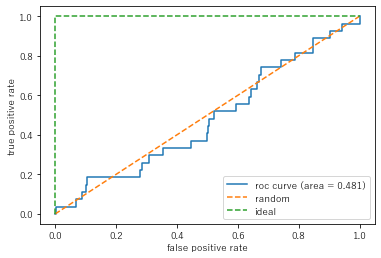

Lasso alpha=0.001
Cross-Validation scores: [0.92063492 0.92063492 0.92063492 0.9047619  0.91489362]
Average score: 0.916
使用された特徴量の数: 27

Lasso回帰
auc:0.542


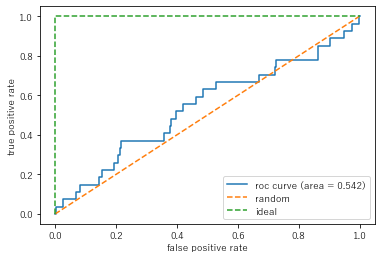

Lasso alpha=0.01
Cross-Validation scores: [0.91534392 0.91005291 0.88888889 0.88888889 0.91489362]
Average score: 0.904
使用された特徴量の数: 63

Lasso回帰
auc:0.583


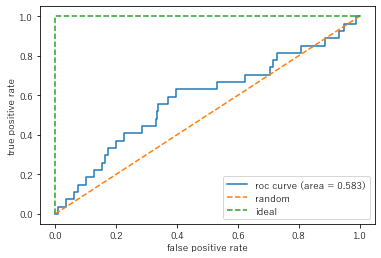

Lasso alpha=0.1
Cross-Validation scores: [0.92063492 0.87301587 0.85185185 0.87301587 0.89361702]
Average score: 0.882
使用された特徴量の数: 123

Lasso回帰
auc:0.612


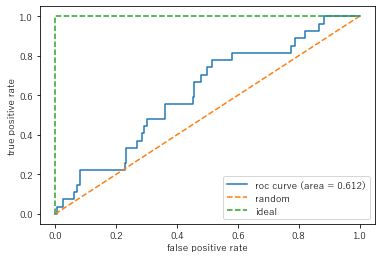

Lasso alpha=1.0
Cross-Validation scores: [0.86243386 0.86243386 0.80952381 0.82010582 0.82446809]
Average score: 0.836
使用された特徴量の数: 186

Lasso回帰
auc:0.730


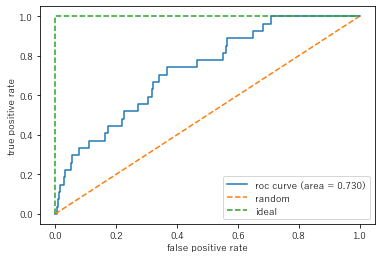

Lasso alpha=10.0
Cross-Validation scores: [0.78835979 0.83597884 0.75661376 0.79365079 0.80319149]
Average score: 0.796
使用された特徴量の数: 242

Lasso回帰
auc:0.691


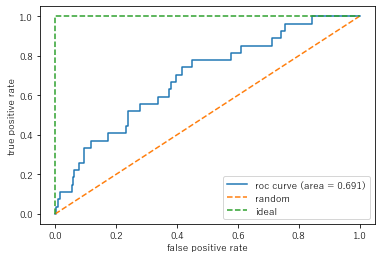

Lasso alpha=100.0
Cross-Validation scores: [0.87830688 0.86243386 0.76190476 0.74603175 0.80851064]
Average score: 0.811
使用された特徴量の数: 294

Lasso回帰
auc:0.697


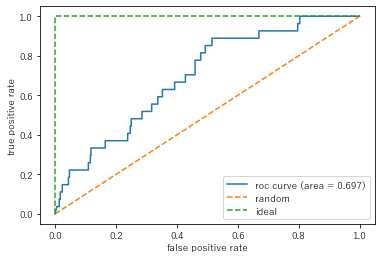

In [11]:
#交差検証とハイパーパラメータのチューニング
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]


for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train,y_train)
    predict_lasso = clf_lasso.predict(x_test)
    predict_lasso_prob = clf_lasso.predict_proba(x_test)

    print(f'Lasso alpha={alpha}')
    scores = cross_val_score(clf_lasso, x_train, y_train,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア

    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')

    Y_score = clf_lasso.predict_proba(x_test)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()


AUCは、ROC (Receiver Operating Characteristic)曲線の下側の面積で、この値が大きいほど分類性能がよいことを示す指標です（最大値は1）。ROC曲線とは、横軸に偽陽性率（FPR: False Positive Rate）を、縦軸に真陽性率（TPR: True Positive Rate）をとった、モデルの分類性能を示した曲線です。クラス分類では、各データがクラス1に属する確率（スコア）を算出し、スコアが閾値を上回っていればデータをクラス1に分類します。したがって、その閾値を変化させると、偽陽性率（実際はクラス0だが誤ってクラス1に分類されるデータの割合）と真陽性率（実際にクラス1で正しくクラス1に分類される確率）が変化します。閾値が極端に大きい場合はどのデータもクラス1に分類されないのでROC曲線は点(0, 0)を通り、閾値が極端に小さい場合はすべてのデータがクラス1に分類されるのでROC曲線は点(1, 1)を通ります。閾値を大きい値から小さい値に変化させていくと、スコアが大きいデータから順にクラス1に分類されるようになります。実際にクラス1のデータのスコアが大きい傾向があれば、真陽性率が偽陽性率よりも早く大きくなり、ROC曲線は点(0, 0)から図の左上を通って点(1, 1)まで描かれます。その結果、ROC曲線の下側の面積であるAUCの値が大きくなります。したがって、AUCは、実際にクラス1のデータに対するスコアが大きめに予測され、実際にクラス0のデータに対するスコアは低めに予測されているかを評価する指標といえます。

In [12]:
#上記の図からalphaのbestparamaetaを決定
best_param=1.0
clf_lasso = LogisticRegression(C=best_param,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
clf_lasso.fit(x_train,y_train)
predict_lasso = clf_lasso.predict(x_test)
predict_lasso_prob = clf_lasso.predict_proba(x_test)

# print(f'lasso回帰の係数: {clf_lasso.coef_}')
print(f'lasso回帰で使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}')

lasso回帰で使用された特徴量の数: 186


In [13]:
# 真値と予測値の表示
df_pred = pd.DataFrame({'Pass/Fail':y_test,'Pass/Fail_pred':predict_lasso})
display(df_pred)

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'Pass/Fail':y_test, 'Pass/Fail 0 _prob':predict_lasso_prob [:,0], 'Pass/Fail 1 _prob':predict_lasso_prob [:,1]})
display(df_pred_prob)

Pass/Fail  Pass/Fail_pred
944           0               0
945           1               0
946           0               1
947           0               0
948           0               0
...         ...             ...
1562          0               0
1563          0               0
1564          0               0
1565          0               0
1566          0               0

[623 rows x 2 columns]

Pass/Fail  Pass/Fail 0 _prob  Pass/Fail 1 _prob
944           0           0.995113       4.886515e-03
945           1           0.989547       1.045315e-02
946           0           0.155580       8.444203e-01
947           0           0.998801       1.199131e-03
948           0           0.999776       2.237075e-04
...         ...                ...                ...
1562          0           1.000000       6.609072e-23
1563          0           1.000000       3.306220e-34
1564          0           0.930916       6.908427e-02
1565          0           0.998410       1.589943e-03
1566          0           0.905910       9.408959e-02

[623 rows x 3 columns]

In [14]:
#lasso回帰によって絞り込まれた特徴量を抽出
lasso_feature_importance = pd.DataFrame(clf_lasso.coef_).T
lasso_feature_importance['columns'] = pd.DataFrame(x_train.columns)
lasso_feature_importance = lasso_feature_importance.rename(columns={0: 'coef'})
lasso_feature_importance_column = lasso_feature_importance.query('coef != 0')['columns']

In [15]:
#trainとtestに格納
x_train = x_train.loc[:,lasso_feature_importance_column]
x_test = x_test.loc[:,lasso_feature_importance_column]

## 多重共線性の確認
一番効果的なのはVIF(Variance Inflation Factor, 分散拡大要因)』だとされている。<br/>
https://betashort-lab.com/%E3%83%87%E3%83%BC%E3%82%BF%E3%82%B5%E3%82%A4%E3%82%A8%E3%83%B3%E3%82%B9/%E7%B5%B1%E8%A8%88%E5%AD%A6/vif/
VIFは**“1つの説明変数と他全ての説明変数との関係性を表す指標”** のことで、相関係数に比べて効率良く多重共線性を評価することができる。<br/>
https://www.ushisky.com/datascience/python-multico-vif/

In [16]:
vif_for_confirmation = x_train.loc[:,x_train.columns]

     VIF_Factor features
0      1.357774        0
1      1.350866        1
2      1.731984        2
3      7.072503        3
4     17.099266        4
..          ...      ...
181   87.088489      574
182  441.285135      576
183    4.704297      577
184    1.233230      585
185    1.340636      589

[186 rows x 2 columns]


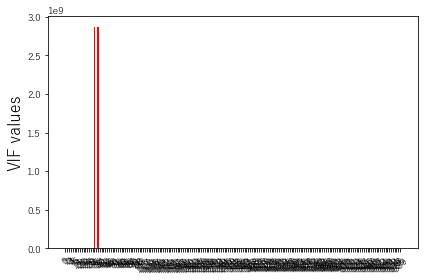

In [17]:
#statsmodelsのvifをインポート
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIFの算出
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(vif_for_confirmation.values, i) for i in range(vif_for_confirmation.shape[1])]
vif["features"] = vif_for_confirmation.columns

# 結果を出力
print(vif)
plt.bar(vif_for_confirmation.columns, vif["VIF_Factor"], color='red')
plt.ylabel('VIF values', fontsize = 16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**一般的にVIF値が10以上の説明変数があると“多重共線性あり”と判断されます。**

In [18]:
vif.query('VIF_Factor >= 10')

VIF_Factor features
4    1.709927e+01        4
9    1.180912e+01       21
10   1.267126e+01       22
16   2.863569e+09       34
17   1.162166e+02       35
..            ...      ...
175  3.688205e+01      564
176  3.708215e+01      566
180  5.199495e+02      572
181  8.708849e+01      574
182  4.412851e+02      576

[91 rows x 2 columns]

**91個の説明変数において多重共線性が確認される**<br/>
どの変数を削除すれば良いのか？<br/>→本来であれば残しておきたい方を考えるのだが、**カラム名の属性情報が分からないため機械的に試していくしかない。**<br/>しかし91!回分プログラムを動かすのは至難なので、今回は<span style="color: red; ">目的変数に与える重要度から説明変数を削除</span>していこうと考える。

In [19]:
x_train_corr_confirm = pd.concat([x_train,y_train],axis=1)

In [22]:
#多重共線性のdfと相関のdfを結合
corr = x_train_corr_confirm.corr()
corr = corr['Pass/Fail'].sort_values(ascending=False).to_frame() #相関の高い説明変数の抽出
corr = corr.rename_axis('features').reset_index().iloc[1:,:].rename(columns={'Pass/Fail': 'correlation'}).astype({'features': int}).sort_values('features').reset_index().drop('index',axis=1)
vif = vif.rename(columns={'VIF_Factor': 'VIF','features': 'VIF_features'})
df_vif_compair = pd.concat([vif,corr['correlation']],axis=1)

In [24]:
#相関の中央値より低く、VIFが10以上の変数は除外する
df_corr_median = df_vif_compair['correlation'].median()
exclusion_variable = df_vif_compair[(df_vif_compair['VIF'] >= 10) & (df_vif_compair['correlation'] < df_corr_median)]['VIF_features'].astype(str)
print(f'除外する変数: {len(exclusion_variable)}')

除外する変数: 39


In [25]:
#変数の選定
x_train = x_train.drop(exclusion_variable,axis=1)
x_test = x_test.drop(exclusion_variable,axis=1)
x_train_corr_confirm =  x_train_corr_confirm.drop(exclusion_variable,axis=1)

# 再度多重共線性の確認

     VIF_Factor features
0      1.304741        0
1      1.268442        1
2      1.508567        2
3      5.121444        3
4      0.000000        5
..          ...      ...
142    1.278801      570
143    1.563392      571
144    1.499781      577
145    1.185343      585
146    1.223892      589

[147 rows x 2 columns]


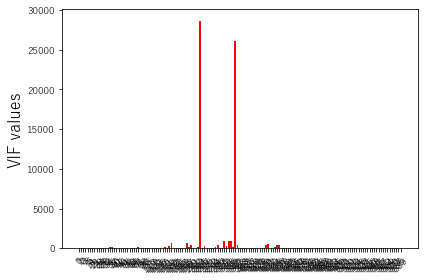

In [26]:
# VIFの算出

vif_for_confirmation = x_train.loc[:,x_train.columns]

# VIFの算出
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(vif_for_confirmation.values, i) for i in range(vif_for_confirmation.shape[1])]
vif["features"] = vif_for_confirmation.columns

# 結果を出力
print(vif)
plt.bar(vif_for_confirmation.columns, vif["VIF_Factor"], color='red')
plt.ylabel('VIF values', fontsize = 16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**これを繰り返して多重共線性がなくなるまで行う**

In [28]:
#多重共線性のdfと相関のdfを結合
corr = x_train_corr_confirm.corr()
corr = corr['Pass/Fail'].sort_values(ascending=False).to_frame() #相関の高い説明変数の抽出
corr = corr.rename_axis('features').reset_index().iloc[1:,:].rename(columns={'Pass/Fail': 'correlation'}).astype({'features': int}).sort_values('features').reset_index().drop('index',axis=1)
vif = vif.rename(columns={'VIF_Factor': 'VIF','features': 'VIF_features'})
df_vif_compair = pd.concat([vif,corr['correlation']],axis=1)

#相関の中央値より低く、VIFが10以上の変数は除外する
df_corr_median = df_vif_compair['correlation'].median()
exclusion_variable = df_vif_compair[(df_vif_compair['VIF'] >= 10) & (df_vif_compair['correlation'] < df_corr_median)]['VIF_features'].astype(str)
print(f'除外する変数: {len(exclusion_variable)}')

#変数の選定
x_train = x_train.drop(exclusion_variable,axis=1)
x_test = x_test.drop(exclusion_variable,axis=1)
x_train_corr_confirm =  x_train_corr_confirm.drop(exclusion_variable,axis=1)

除外する変数: 4


     VIF_Factor features
0      1.297089        0
1      1.266285        1
2      1.504507        2
3      5.072571        3
4      0.000000        5
..          ...      ...
138    1.276180      570
139    1.528857      571
140    1.491587      577
141    1.176442      585
142    1.218945      589

[143 rows x 2 columns]


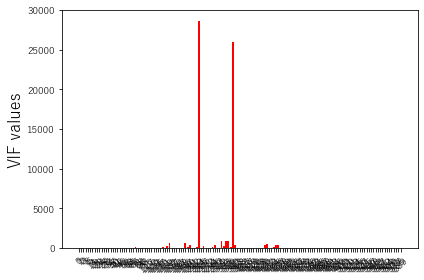

In [29]:
# VIFの算出

vif_for_confirmation = x_train.loc[:,x_train.columns]

# VIFの算出
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(vif_for_confirmation.values, i) for i in range(vif_for_confirmation.shape[1])]
vif["features"] = vif_for_confirmation.columns

# 結果を出力
print(vif)
plt.bar(vif_for_confirmation.columns, vif["VIF_Factor"], color='red')
plt.ylabel('VIF values', fontsize = 16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
#多重共線性のdfと相関のdfを結合
corr = x_train_corr_confirm.corr()
corr = corr['Pass/Fail'].sort_values(ascending=False).to_frame() #相関の高い説明変数の抽出
corr = corr.rename_axis('features').reset_index().iloc[1:,:].rename(columns={'Pass/Fail': 'correlation'}).astype({'features': int}).sort_values('features').reset_index().drop('index',axis=1)
vif = vif.rename(columns={'VIF_Factor': 'VIF','features': 'VIF_features'})
df_vif_compair = pd.concat([vif,corr['correlation']],axis=1)

#相関の中央値より低く、VIFが10以上の変数は除外する
df_corr_median = df_vif_compair['correlation'].median()
exclusion_variable = df_vif_compair[(df_vif_compair['VIF'] >= 10) & (df_vif_compair['correlation'] < df_corr_median)]['VIF_features'].astype(str)
print(f'除外する変数: {len(exclusion_variable)}')

#変数の選定
x_train = x_train.drop(exclusion_variable,axis=1)
x_test = x_test.drop(exclusion_variable,axis=1)
x_train_corr_confirm =  x_train_corr_confirm.drop(exclusion_variable,axis=1)

除外する変数: 0


In [32]:
print(f'多重共線性除外後の特徴量:{len(x_train.columns)}')

多重共線性除外後の特徴量:143


**まだ多重共線性が発生している変数があるものの、、一度現時点での機械学習を実装してみる**

Lasso alpha=0.0001
Cross-Validation scores: [0.92063492 0.92063492 0.91534392 0.91534392 0.92021277]
Average score: 0.918
使用された特徴量の数: 4

Lasso回帰
auc:0.476


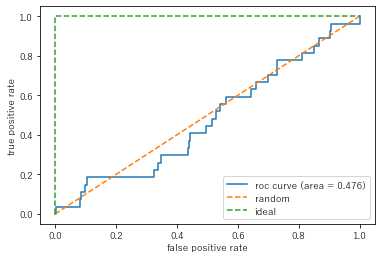

Lasso alpha=0.001
Cross-Validation scores: [0.92063492 0.92063492 0.92063492 0.9047619  0.91489362]
Average score: 0.916
使用された特徴量の数: 25

Lasso回帰
auc:0.537


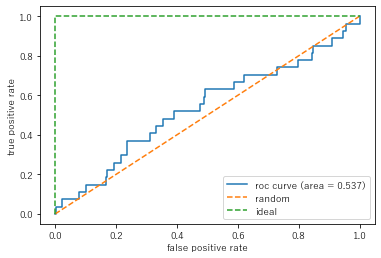

Lasso alpha=0.01
Cross-Validation scores: [0.91534392 0.91534392 0.88888889 0.88888889 0.91489362]
Average score: 0.905
使用された特徴量の数: 55

Lasso回帰
auc:0.599


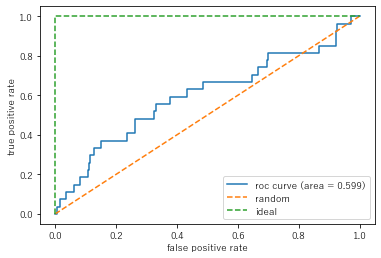

Lasso alpha=0.1
Cross-Validation scores: [0.91005291 0.87830688 0.83068783 0.86243386 0.91489362]
Average score: 0.879
使用された特徴量の数: 100

Lasso回帰
auc:0.655


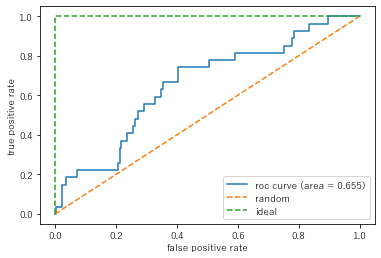

Lasso alpha=1.0
Cross-Validation scores: [0.9047619  0.88359788 0.78835979 0.83597884 0.89361702]
Average score: 0.861
使用された特徴量の数: 139

Lasso回帰
auc:0.740


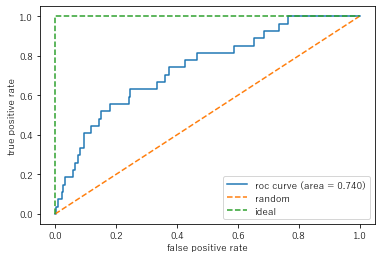

Lasso alpha=10.0
Cross-Validation scores: [0.88359788 0.87301587 0.76190476 0.84126984 0.87765957]
Average score: 0.847
使用された特徴量の数: 143

Lasso回帰
auc:0.754


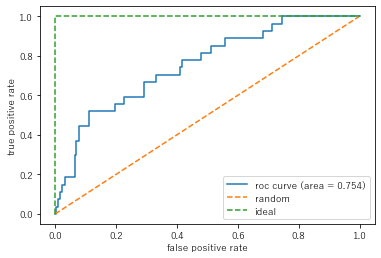

Lasso alpha=100.0
Cross-Validation scores: [0.89417989 0.87301587 0.74603175 0.85714286 0.87234043]
Average score: 0.849
使用された特徴量の数: 143

Lasso回帰
auc:0.755


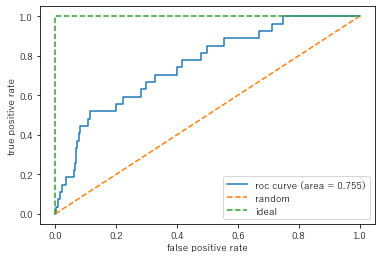

In [33]:
#交差検証とハイパーパラメータのチューニング
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]


for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train,y_train)
    predict_lasso = clf_lasso.predict(x_test)
    predict_lasso_prob = clf_lasso.predict_proba(x_test)
    
    print(f'Lasso alpha={alpha}')
    
    scores = cross_val_score(clf_lasso, x_train, y_train,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア
    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')
    
    Y_score = clf_lasso.predict_proba(x_test)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()


**AUCも多少向上している**

In [34]:
#上記の図からalphaのbestparamaetaを決定
best_param=100.0
clf_lasso = LogisticRegression(C=best_param,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
clf_lasso.fit(x_train,y_train)
predict_lasso = clf_lasso.predict(x_test)
predict_lasso_prob = clf_lasso.predict_proba(x_test)

print(f'lasso回帰の係数: {clf_lasso.coef_}')
print(f'lasso回帰で使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}')

lasso回帰の係数: [[-5.89212981e-04 -9.15394153e-04 -1.14484318e-02 -1.93537988e-03
   6.86473259e-02  2.90024544e-02 -2.13541817e-01  4.15774344e-02
   2.55218832e-03 -5.66056477e-05  9.35438690e-05  1.31601701e-01
  -9.76954574e-02  1.89254497e-01 -2.83296917e-02  2.36542242e-01
  -8.51840675e-03 -2.95384552e-01  1.06789969e-01  2.64764886e-02
  -8.86457725e-04  1.72338234e-01  2.57377920e-01  4.36867559e-01
  -2.43556320e-01  1.61559574e-04  1.82108955e-02 -9.14438456e-04
  -1.02242260e-03 -8.87802307e-01 -5.91794658e-03 -4.25189822e-01
  -9.52920673e-01  5.19605559e-01  2.54283256e-02  1.42657458e-03
   3.33951431e-02 -1.03400445e-02 -1.73077282e-01  8.43547721e-04
  -4.03294989e-03 -2.32753641e-04 -3.59435358e+00 -1.64984993e-01
   3.81936001e-02  1.81955840e-01  7.68555624e-02  2.48183315e-01
  -1.93950009e-01  3.48651922e-01 -1.88634991e-01 -1.14590111e-01
   1.04554528e-01 -5.08682798e-02  2.91865300e-01 -4.47489172e-01
  -1.73935208e-02 -7.15241036e-02  4.82623201e-02 -4.40503398e-0

反復特徴量選択　→**【実装結果】**説明変数30個まで絞り込んだがAUCを下げた<br/> 
https://qiita.com/rockhopper/items/a68ceb3248f2b3a41c89

まったく特徴量を使わないところから、ある基準が満たされるまで1つずつ重要度が高い特徴量を加えていく、もしくは、すべての特徴量を使う状態から1つずつ特徴量を取り除いていくという操作を繰り返すことで特徴量を選択する。

****

In [42]:
#lasso回帰によって絞り込まれた特徴量を抽出
lasso_feature_importance = pd.DataFrame(clf_lasso.coef_).T
lasso_feature_importance['columns'] = pd.DataFrame(x_train.columns)
lasso_feature_importance = lasso_feature_importance.rename(columns={0: 'coef'})
lasso_feature_importance_column = lasso_feature_importance.query('coef != 0')['columns']

x_train = x_train.loc[:,lasso_feature_importance_column]
x_test = x_test.loc[:,lasso_feature_importance_column]
x_train_corr_confirm = x_train_corr_confirm.loc[:,lasso_feature_importance_column]
x_train_corr_confirm['Pass/Fail'] = y_train

## Group Lassoの実装
https://qiita.com/AnchorBlues/items/4e50d3b98a40c8b3086e

In [43]:
from grouplasso import GroupLassoRegressor, GroupLassoClassifier

In [44]:
corr = x_train_corr_confirm.corr()
corr = pd.DataFrame(corr['Pass/Fail'].sort_values(ascending=False)[1:])
corr['abs'] = abs(corr['Pass/Fail'])
corr = corr.sort_values('abs',ascending=False)

In [45]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',        # 目的 : 2クラス分類  
        'metric': {'binary_error'},   # 評価指標 : 誤り率(= 1-正答率) 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# 特徴量重要度の算出 (データフレームで取得)
cols = x_train.columns # 特徴量名のリスト(目的変数と欠損値以外)

f_importance = np.array(model.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance.query('importance == 0')) #重要度が低い(ない)変数
display(df_importance.query('importance > 0')) #重要度があるor高い変数

[LightGBM] [Info] Number of positive: 77, number of negative: 867
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33508
[LightGBM] [Info] Number of data points in the train set: 944, number of used features: 140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081568 -> initscore=-2.421234
[LightGBM] [Info] Start training from score -2.421234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.0433387
[2]	valid_0's binary_error: 0.0433387
[3]	valid_0's binary_error: 0.0433387
[4]	valid_0's binary_error: 0.0433387
[5]	valid_0's binary_error: 0.0433387
[6]	valid_0's binary_error: 0.0433387
[7]	valid_0's binary_error: 0.0433387
[8]	valid_0's binary_error: 0.0433387
[9]	valid_0's binary_error: 0.0433387
[10]	valid_0's binary_error: 0.0433387
[11]	valid_0's binary_error: 0.0433387
[12]	valid_0'

feature  importance
18       42         0.0
120     521         0.0
4         5         0.0

feature  importance
21       59    0.067513
8        21    0.030080
31      117    0.021056
14       34    0.018382
32      122    0.017045
..      ...         ...
82      430    0.001671
136     564    0.001671
35      136    0.001337
115     499    0.001003
50      201    0.001003

[140 rows x 2 columns]

In [46]:
#group_lasso
gr_ls_corr = pd.DataFrame(x_train.columns,columns={'features'})
gr_ls_corr['id'] = 0
gr_ls_corr = gr_ls_corr.set_index('features')

gr_ls_gbm = pd.DataFrame(x_train.columns,columns={'features'})
gr_ls_gbm['id'] = 0
gr_ls_gbm = gr_ls_gbm.set_index('features')

#相関・lightgbm上位10
corr_gr_ls = corr['abs'].sort_values(ascending=False)[0:10].index
corr_lightgbm_ls = df_importance[0:10].feature

#該当する変数にフラグ付け
gr_ls_corr.loc[corr_gr_ls,'id'] = 1
gr_ls_gbm.loc[corr_lightgbm_ls,'id'] = 1

In [47]:
corr

Pass/Fail       abs
21    0.145753  0.145753
59    0.132822  0.132822
117  -0.116118  0.116118
431   0.114916  0.114916
510   0.110899  0.110899
..         ...       ...
570  -0.001438  0.001438
415   0.001230  0.001230
585  -0.000644  0.000644
5          NaN       NaN
42         NaN       NaN

[143 rows x 2 columns]

In [48]:
#groupidのためのラベル付け
#143個の説明変数があるため、groupidは12個ずつに分割 → 多く取りすぎて除外できる変数なし
#143個の説明変数があるため、groupidは5個ずつに分割

corr_gr_ls = corr['abs'].sort_values(ascending=False)[0:5].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 1
corr_gr_ls = corr['abs'].sort_values(ascending=False)[5:10].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 2
corr_gr_ls = corr['abs'].sort_values(ascending=False)[10:15].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 3
corr_gr_ls = corr['abs'].sort_values(ascending=False)[15:20].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 4
corr_gr_ls = corr['abs'].sort_values(ascending=False)[20:25].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 5
corr_gr_ls = corr['abs'].sort_values(ascending=False)[25:30].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 6
corr_gr_ls = corr['abs'].sort_values(ascending=False)[30:35].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 7
corr_gr_ls = corr['abs'].sort_values(ascending=False)[35:40].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 8
corr_gr_ls = corr['abs'].sort_values(ascending=False)[40:45].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 9
corr_gr_ls = corr['abs'].sort_values(ascending=False)[45:50].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 10
corr_gr_ls = corr['abs'].sort_values(ascending=False)[50:55].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 11
corr_gr_ls = corr['abs'].sort_values(ascending=False)[55:60].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 12
corr_gr_ls = corr['abs'].sort_values(ascending=False)[60:65].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 13
corr_gr_ls = corr['abs'].sort_values(ascending=False)[65:70].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 14
corr_gr_ls = corr['abs'].sort_values(ascending=False)[70:75].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 15
corr_gr_ls = corr['abs'].sort_values(ascending=False)[75:80].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 16
corr_gr_ls = corr['abs'].sort_values(ascending=False)[80:85].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 17
corr_gr_ls = corr['abs'].sort_values(ascending=False)[85:90].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 18
corr_gr_ls = corr['abs'].sort_values(ascending=False)[90:95].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 19
corr_gr_ls = corr['abs'].sort_values(ascending=False)[95:100].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 20
corr_gr_ls = corr['abs'].sort_values(ascending=False)[100:105].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 21
corr_gr_ls = corr['abs'].sort_values(ascending=False)[105:110].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 22
corr_gr_ls = corr['abs'].sort_values(ascending=False)[110:115].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 23
corr_gr_ls = corr['abs'].sort_values(ascending=False)[115:120].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 24
corr_gr_ls = corr['abs'].sort_values(ascending=False)[120:125].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 25
corr_gr_ls = corr['abs'].sort_values(ascending=False)[125:130].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 26
corr_gr_ls = corr['abs'].sort_values(ascending=False)[130:135].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 27
corr_gr_ls = corr['abs'].sort_values(ascending=False)[135:140].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 28
corr_gr_ls = corr['abs'].sort_values(ascending=False)[140:143].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 29

In [49]:
#グループ番号の設定
group_ids_corr = np.array(gr_ls_corr['id'])
group_ids_gbm = np.array(gr_ls_gbm['id'])

In [50]:
group_ids_corr

array([22, 26, 15, 20, 29, 25,  8, 23,  1, 26, 15, 25,  5,  5, 20, 22,  9,
       27, 29, 23, 26,  1, 16,  3,  5, 11, 21, 23, 10, 15, 10,  1,  6, 20,
        4, 19, 14, 21, 19,  4,  3, 15, 17,  3, 18, 27, 12,  6,  7,  6, 10,
        8,  4, 13, 10, 12, 13, 16, 17,  4,  3, 14, 15, 11,  8, 13, 11,  6,
       12, 16, 18, 20, 19, 28,  3,  8, 22, 14, 28, 23, 17, 27,  2,  1, 28,
        6,  2,  2,  2,  4, 10, 27, 19, 25,  7, 24, 14, 17, 14,  9, 11, 11,
       24, 18, 21,  7,  8, 20, 25, 12, 27, 17, 13, 12, 22, 18, 18,  1,  5,
       26,  5, 24, 21, 23, 16,  2, 19,  9, 16, 28, 21, 13, 24,  7, 24, 25,
       22,  7, 28,  9,  9, 29, 26], dtype=int64)

In [51]:
group_ids_corr = np.array([22, 26, 15, 20, 29, 25,  8, 23,  1, 26, 15, 25,  5,  5, 20, 22,  9,
       27, 29, 23, 26,  1, 16,  3,  5, 11, 21, 23, 10, 15, 10,  1,  6, 20,
        4, 19, 14, 21, 19,  4,  3, 15, 17,  3, 18, 27, 12,  6,  7,  6, 10,
        8,  4, 13, 10, 12, 13, 16, 17,  4,  3, 14, 15, 11,  8, 13, 11,  6,
       12, 16, 18, 20, 19, 28,  3,  8, 22, 14, 28, 23, 17, 27,  2,  1, 28,
        6,  2,  2,  2,  4, 10, 27, 19, 25,  7, 24, 14, 17, 14,  9, 11, 11,
       24, 18, 21,  7,  8, 20, 25, 12, 27, 17, 13, 12, 22, 18, 18,  1,  5,
       26,  5, 24, 21, 23, 16,  2, 19,  9, 16, 28, 21, 13, 24,  7, 24, 25,
       22,  7, 28,  9,  9, 29, 26])

In [52]:
x_train_sca = StandardScaler().fit_transform(x_train)

In [53]:
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]
coef_list = []
eta = 0.2    # 学習率
for alpha in param_grid:
    gr_ls_model = GroupLassoClassifier(group_ids=group_ids_corr, random_state=42, alpha=alpha, verbose=False, eta=eta)

    # モデルの学習
    gr_ls_model.fit(x_train_sca, y_train)

    # モデルの偏回帰係数を出力
    print(f'alpha={alpha}')
    print(gr_ls_model.coef_)
    coef_list.append(gr_ls_model.coef_)

alpha=0.0001
[-2.64041827e-02 -1.19230871e-01 -2.04961456e-01 -1.78727459e-01
  0.00000000e+00  5.91044906e-03 -1.24207337e-01  1.21516450e-01
  7.87403639e-01  3.17848869e-02  1.00215977e-01  3.32919814e-01
 -1.00553880e-02  2.83196971e-01 -2.28210555e-01  7.53935417e-02
 -1.44230388e-01 -3.02525798e-01  0.00000000e+00 -1.40011208e-01
  2.19992209e-02  1.00524366e+00 -7.67183210e-02  8.39643527e-01
 -1.23009565e-01 -1.43732590e-01  1.48754343e-01 -4.45114022e-02
 -1.27859933e-01 -1.15217628e-01 -1.07834850e-01 -3.96973639e-01
 -2.51101863e-01  1.72589350e-01  2.37843696e-01 -4.81046139e-02
  2.18628383e-01 -6.21027842e-03 -5.03870124e-01  4.67630456e-02
 -3.65419798e-03 -2.91101087e-02 -5.26191912e-01 -3.53914340e-01
 -1.97349945e-02  1.06848260e-01  1.03161194e-01  5.88647078e-02
  3.45171891e-01  1.99043725e-01  2.89735302e-02 -1.96192953e-01
  2.11800993e-01 -6.04244734e-02  2.26028679e-01 -2.97229664e-01
  1.05220684e-01 -1.62955988e-01  3.74629765e-01  2.53043821e-02
  6.42176097

In [54]:
alpha_df = pd.DataFrame(coef_list,index={"0.0001", "0.001", "0.01", "0.1", "1.0", "10.0", "100.0"}).T
gr_ls_df = pd.DataFrame(x_train.columns,columns={'features'})
gr_ls_df['group_id'] = group_ids_corr
gr_ls_df = pd.concat([gr_ls_df,alpha_df],axis=1)
gr_ls_df = gr_ls_df.set_index('features')

In [55]:
pd.DataFrame(x_train.columns)

0
0      0
1      1
2      2
3      3
4      5
..   ...
138  570
139  571
140  577
141  585
142  589

[143 rows x 1 columns]

In [56]:
for i in range(len(dict.fromkeys(group_ids_corr))):
    display(gr_ls_df[gr_ls_df['group_id'] == i+1])

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
21               1  0.787404  0.733225  0.340548   0.0    0.0     0.0    0.0
59               1  1.005244  0.952889  0.451314   0.0    0.0     0.0    0.0
117              1 -0.396974 -0.388225 -0.281626  -0.0   -0.0    -0.0   -0.0
431              1  0.068545  0.054094  0.001103   0.0    0.0     0.0    0.0
510              1  0.016124  0.029101  0.118237   0.0    0.0     0.0    0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
430              2  0.141518  0.093141 -0.004579   0.0    0.0     0.0    0.0
434              2  0.002577 -0.008344 -0.007619   0.0    0.0     0.0    0.0
435              2 -0.170784 -0.137678 -0.013114   0.0    0.0     0.0    0.0
436              2 -0.181400 -0.144047 -0.013353   0.0    0.0     0.0    0.0
527              2 -0.317319 -0.278991 -0.065052  -0.0   -0.0    -0.0   -0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
64               3  0.839644  0.764186  0.298812   0.0    0.0     0.0    0.0
160              3 -0.003654 -0.000146  0.031889   0.0    0.0     0.0    0.0
180              3 -0.353914 -0.319848 -0.146519  -0.0   -0.0    -0.0   -0.0
295              3  0.064218  0.063328  0.052288   0.0    0.0     0.0    0.0
416              3 -0.392684 -0.381708 -0.266267  -0.0   -0.0    -0.0   -0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
133              4  0.237844  0.217557  0.137466   0.0    0.0     0.0    0.0
159              4  0.046763  0.038298 -0.019843   0.0    0.0     0.0    0.0
203              4  0.211801  0.181426  0.091800   0.0    0.0     0.0    0.0
294              4  0.025304  0.020421 -0.018378   0.0    0.0     0.0    0.0
437              4  0.154680  0.155537  0.128334   0.0    0.0     0.0    0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
28               5 -0.010055 -0.008724 -0.025148  -0.0   -0.0    -0.0   -0.0
32               5  0.283197  0.262550  0.130758   0.0    0.0     0.0    0.0
65               5 -0.123010 -0.103198  0.022828   0.0    0.0     0.0    0.0
511              5  0.257869  0.246335  0.146481   0.0    0.0     0.0    0.0
521              5  0.307825  0.279211  0.134986   0.0    0.0     0.0    0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
122              6 -0.251102 -0.219868 -0.046799  -0.0   -0.0    -0.0   -0.0
196              6  0.058865  0.041335  0.004904   0.0    0.0     0.0    0.0
199              6  0.199044  0.140940  0.008555   0.0    0.0     0.0    0.0
339              6  0.000152  0.006623  0.010928   0.0    0.0     0.0    0.0
433              6 -0.044829 -0.026509  0.026322   0.0    0.0     0.0    0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
197              7  0.345172  0.292826  0.041886   0.0    0.0     0.0    0.0
453              7 -0.273341 -0.247185 -0.092695  -0.0   -0.0    -0.0   -0.0
484              7 -0.124643 -0.119489 -0.068892  -0.0   -0.0    -0.0   -0.0
557              7  0.248465  0.202307  0.054268   0.0    0.0     0.0    0.0
569              7  0.108382  0.108832  0.097384   0.0    0.0     0.0    0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
14               8 -0.124207 -0.108561 -0.043040  -0.0   -0.0    -0.0   -0.0
202              8 -0.196193 -0.133616 -0.004809   0.0    0.0     0.0    0.0
333              8  0.260117  0.200950  0.004055   0.0    0.0     0.0    0.0
417              8 -0.164414 -0.153866 -0.043112  -0.0   -0.0    -0.0   -0.0
485              8 -0.241691 -0.214071 -0.046515  -0.0   -0.0    -0.0   -0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
40               9 -0.144230 -0.128519 -0.041155  -0.0   -0.0    -0.0   -0.0
470              9  0.067048  0.057944  0.003425   0.0    0.0     0.0    0.0
545              9 -0.316484 -0.298625 -0.149874  -0.0   -0.0    -0.0   -0.0
571              9 -0.291070 -0.281426 -0.177414  -0.0   -0.0    -0.0   -0.0
577              9 -0.438954 -0.402937 -0.154202  -0.0   -0.0    -0.0   -0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
90              10 -0.127860 -0.116265 -0.053208  -0.0   -0.0    -0.0   -0.0
115             10 -0.107835 -0.099009 -0.053928  -0.0   -0.0    -0.0   -0.0
201             10  0.028974  0.042582  0.041514   0.0    0.0     0.0    0.0
205             10  0.226029  0.133859 -0.029649   0.0    0.0     0.0    0.0
438             10  0.049522  0.041952  0.027987   0.0    0.0     0.0    0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
67              11 -0.143733 -0.132165 -0.074860   0.0    0.0     0.0    0.0
332             11 -0.316853 -0.255987 -0.067170   0.0    0.0     0.0    0.0
336             11 -0.095841 -0.082429 -0.046519   0.0    0.0     0.0    0.0
472             11  0.179199  0.162975  0.118492   0.0    0.0     0.0    0.0
474             11  0.250503  0.191447  0.023376   0.0    0.0     0.0    0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
188             12  0.103161  0.068068  0.013667   0.0    0.0     0.0    0.0
207             12 -0.297230 -0.234159 -0.040852   0.0    0.0     0.0    0.0
340             12 -0.026297 -0.034944 -0.025802   0.0    0.0     0.0    0.0
488             12 -0.221849 -0.198451 -0.050212  -0.0   -0.0    -0.0   -0.0
494             12  0.045783  0.048621  0.039966   0.0    0.0     0.0    0.0

group_id       1.0      10.0  0.1  0.01  0.001  0.0001  100.0
features                                                               
204             13 -0.060424 -0.051045 -0.0   0.0    0.0     0.0    0.0
271             13  0.105221  0.073470  0.0   0.0    0.0     0.0    0.0
335             13 -0.233040 -0.158215 -0.0   0.0    0.0     0.0    0.0
493             13 -0.093208 -0.071254  0.0   0.0    0.0     0.0    0.0
550             13 -0.207235 -0.157879 -0.0   0.0    0.0     0.0    0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
137             14  0.218628  0.165523  0.023338   0.0    0.0     0.0    0.0
297             14  0.229981  0.200504  0.057967   0.0    0.0     0.0    0.0
419             14  0.168456  0.160854  0.052894   0.0    0.0     0.0    0.0
460             14  0.305490  0.260103  0.047206   0.0    0.0     0.0    0.0
468             14  0.082533  0.060417 -0.004740  -0.0   -0.0    -0.0   -0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
2               15 -0.204961 -0.183362 -0.029711  -0.0   -0.0    -0.0   -0.0
24              15  0.100216  0.082258 -0.002136  -0.0   -0.0    -0.0   -0.0
98              15 -0.115218 -0.094568 -0.014082  -0.0   -0.0    -0.0   -0.0
162             15 -0.029110 -0.007626  0.017902   0.0    0.0     0.0    0.0
324             15 -0.215222 -0.156340 -0.000332   0.0    0.0     0.0    0.0

group_id       1.0      10.0  0.1  0.01  0.001  0.0001  100.0
features                                                               
63              16 -0.076718 -0.084149 -0.0   0.0    0.0     0.0    0.0
272             16 -0.162956 -0.114688  0.0   0.0    0.0     0.0    0.0
343             16 -0.248920 -0.186416 -0.0   0.0    0.0     0.0    0.0
526             16  0.032916  0.026034 -0.0  -0.0   -0.0    -0.0   -0.0
546             16  0.126446  0.099210 -0.0  -0.0   -0.0    -0.0   -0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
177             17 -0.526192 -0.476621 -0.166126  -0.0   -0.0    -0.0   -0.0
274             17  0.374630  0.312956  0.052494   0.0    0.0     0.0    0.0
428             17 -0.417045 -0.366604 -0.091746  -0.0   -0.0    -0.0   -0.0
467             17  0.015870  0.019012  0.034035   0.0    0.0     0.0    0.0
491             17  0.022031  0.020461  0.031770   0.0    0.0     0.0    0.0

group_id       1.0      10.0  0.1  0.01  0.001  0.0001  100.0
features                                                               
185             18 -0.019735 -0.023376 -0.0  -0.0   -0.0    -0.0   -0.0
363             18 -0.078461 -0.047412  0.0   0.0    0.0     0.0    0.0
482             18 -0.118421 -0.102074 -0.0  -0.0   -0.0    -0.0   -0.0
499             18 -0.022553 -0.022260 -0.0  -0.0   -0.0    -0.0   -0.0
500             18  0.005971 -0.001374 -0.0  -0.0   -0.0    -0.0   -0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
136             19 -0.048105 -0.027639  0.005572   0.0    0.0     0.0    0.0
151             19 -0.503870 -0.419641 -0.063414  -0.0   -0.0    -0.0   -0.0
412             19 -0.235831 -0.191215 -0.001748   0.0    0.0     0.0    0.0
440             19 -0.164883 -0.127146  0.022415   0.0    0.0     0.0    0.0
541             19  0.328190  0.300939  0.076195   0.0    0.0     0.0    0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
3               20 -0.178727 -0.157238 -0.031955  -0.0   -0.0    -0.0   -0.0
34              20 -0.228211 -0.189979 -0.022876   0.0    0.0     0.0    0.0
129             20  0.172589  0.151217  0.043741   0.0    0.0     0.0    0.0
388             20  0.107700  0.078787  0.017931   0.0    0.0     0.0    0.0
486             20  0.288653  0.256274  0.052076   0.0    0.0     0.0    0.0

group_id       1.0      10.0  0.1  0.01  0.001  0.0001  100.0
features                                                               
71              21  0.148754  0.120007  0.0   0.0    0.0     0.0    0.0
139             21 -0.006210 -0.008100  0.0   0.0    0.0     0.0    0.0
483             21 -0.016443 -0.008633  0.0  -0.0   -0.0    -0.0   -0.0
524             21  0.052780  0.038600 -0.0   0.0    0.0     0.0    0.0
548             21 -0.108444 -0.095318 -0.0  -0.0   -0.0    -0.0   -0.0

group_id       1.0      10.0  0.1  0.01  0.001  0.0001  100.0
features                                                               
0               22 -0.026404 -0.016029  0.0  -0.0   -0.0    -0.0   -0.0
37              22  0.075394  0.055166 -0.0   0.0    0.0     0.0    0.0
418             22 -0.076283 -0.070313 -0.0  -0.0   -0.0    -0.0   -0.0
496             22 -0.227569 -0.186697 -0.0  -0.0   -0.0    -0.0   -0.0
564             22  0.060222  0.056784  0.0   0.0    0.0     0.0    0.0

group_id       1.0      10.0  0.1  0.01  0.001  0.0001  100.0
features                                                               
15              23  0.121516  0.078250 -0.0  -0.0   -0.0    -0.0   -0.0
45              23 -0.140011 -0.103200 -0.0   0.0    0.0     0.0    0.0
88              23 -0.044511 -0.032199  0.0   0.0    0.0     0.0    0.0
423             23  0.031427  0.022340 -0.0   0.0    0.0     0.0    0.0
525             23 -0.053039 -0.048401 -0.0   0.0    0.0     0.0    0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
456             24 -0.011338  0.004888  0.011199  -0.0   -0.0    -0.0   -0.0
476             24 -0.284396 -0.248598 -0.047489   0.0    0.0     0.0    0.0
523             24 -0.495089 -0.441733 -0.094993  -0.0   -0.0    -0.0   -0.0
555             24 -0.141776 -0.116500 -0.016048   0.0    0.0     0.0    0.0
561             24  0.049477  0.048649  0.027905   0.0    0.0     0.0    0.0

group_id       1.0      10.0       0.1  0.01  0.001  0.0001  100.0
features                                                                    
6               25  0.005910  0.001043  0.012234   0.0    0.0     0.0    0.0
27              25  0.332920  0.284737  0.077332   0.0    0.0     0.0    0.0
445             25  0.323673  0.295394  0.070387   0.0    0.0     0.0    0.0
487             25  0.220576  0.207141  0.070128   0.0    0.0     0.0    0.0
562             25 -0.119428 -0.114781 -0.038279  -0.0   -0.0    -0.0   -0.0

group_id       1.0      10.0  0.1  0.01  0.001  0.0001  100.0
features                                                               
1               26 -0.119231 -0.108229 -0.0   0.0    0.0     0.0    0.0
23              26  0.031785  0.024948 -0.0   0.0    0.0     0.0    0.0
55              26  0.021999  0.004027 -0.0  -0.0   -0.0    -0.0   -0.0
520             26 -0.249746 -0.177092 -0.0   0.0    0.0     0.0    0.0
589             26 -0.027479 -0.022888 -0.0   0.0    0.0     0.0    0.0

group_id       1.0      10.0  0.1  0.01  0.001  0.0001  100.0
features                                                               
41              27 -0.302526 -0.248511 -0.0  -0.0   -0.0    -0.0   -0.0
187             27  0.106848  0.087432  0.0  -0.0   -0.0    -0.0   -0.0
429             27 -0.042939 -0.025479  0.0  -0.0   -0.0    -0.0   -0.0
439             27 -0.166301 -0.136081 -0.0  -0.0   -0.0    -0.0   -0.0
489             27  0.177515  0.152247  0.0  -0.0   -0.0    -0.0   -0.0

group_id       1.0      10.0  0.1  0.01  0.001  0.0001  100.0
features                                                               
415             28 -0.293644 -0.243257 -0.0   0.0    0.0     0.0    0.0
420             28  0.168159  0.139874  0.0   0.0    0.0     0.0    0.0
432             28 -0.199373 -0.165258 -0.0  -0.0   -0.0    -0.0   -0.0
547             28  0.043564  0.034364 -0.0   0.0    0.0     0.0    0.0
570             28 -0.040551 -0.043719 -0.0  -0.0   -0.0    -0.0   -0.0

group_id       1.0      10.0  0.1  0.01  0.001  0.0001  100.0
features                                                               
5               29  0.000000  0.000000  0.0   0.0    0.0     0.0    0.0
42              29  0.000000  0.000000  0.0   0.0    0.0     0.0    0.0
585             29  0.106525  0.067953  0.0  -0.0   -0.0    -0.0   -0.0

#### 「5」と「42」と「585」の説明変数は除外する

In [57]:
x_train_gr_lasso = x_train.copy()
x_test_gr_lasso = x_test.copy()

#変数の選定
x_train_gr_lasso = x_train_gr_lasso.drop(['5','42','585'],axis=1)
x_test_gr_lasso = x_test_gr_lasso.drop(['5', '42','585'],axis=1)

In [58]:
corr

Pass/Fail       abs
21    0.145753  0.145753
59    0.132822  0.132822
117  -0.116118  0.116118
431   0.114916  0.114916
510   0.110899  0.110899
..         ...       ...
570  -0.001438  0.001438
415   0.001230  0.001230
585  -0.000644  0.000644
5          NaN       NaN
42         NaN       NaN

[143 rows x 2 columns]

Lasso alpha=0.0001
Cross-Validation scores: [0.92063492 0.92063492 0.91534392 0.91534392 0.92021277]
Average score: 0.918
使用された特徴量の数: 4

Lasso回帰
auc:0.476


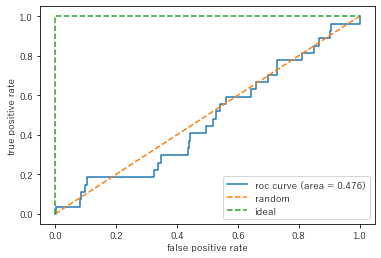

Lasso alpha=0.001
Cross-Validation scores: [0.92063492 0.92063492 0.92063492 0.9047619  0.91489362]
Average score: 0.916
使用された特徴量の数: 24

Lasso回帰
auc:0.537


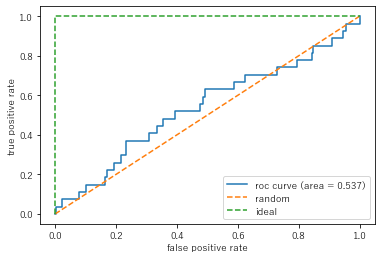

Lasso alpha=0.01
Cross-Validation scores: [0.91534392 0.91534392 0.88888889 0.88888889 0.91489362]
Average score: 0.905
使用された特徴量の数: 55

Lasso回帰
auc:0.598


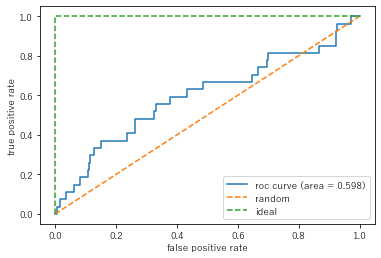

Lasso alpha=0.1
Cross-Validation scores: [0.91005291 0.87830688 0.83068783 0.86772487 0.91489362]
Average score: 0.880
使用された特徴量の数: 100

Lasso回帰
auc:0.654


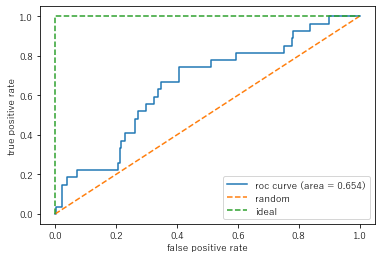

Lasso alpha=1.0
Cross-Validation scores: [0.8994709  0.88359788 0.77777778 0.84126984 0.89361702]
Average score: 0.859
使用された特徴量の数: 137

Lasso回帰
auc:0.739


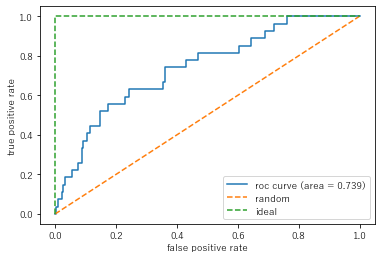

Lasso alpha=10.0
Cross-Validation scores: [0.88888889 0.87301587 0.76719577 0.84126984 0.87765957]
Average score: 0.850
使用された特徴量の数: 140

Lasso回帰
auc:0.756


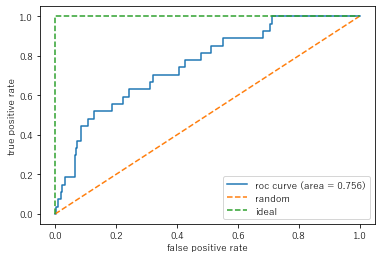

Lasso alpha=100.0
Cross-Validation scores: [0.8994709  0.86243386 0.76719577 0.84656085 0.87234043]
Average score: 0.850
使用された特徴量の数: 140

Lasso回帰
auc:0.754


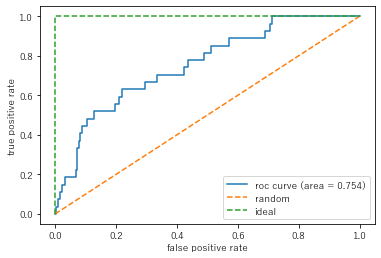

In [59]:
#交差検証とハイパーパラメータのチューニング
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_gr_lasso,y_train)
    predict_lasso = clf_lasso.predict(x_test_gr_lasso)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_gr_lasso)
    
    print(f'Lasso alpha={alpha}')

    scores = cross_val_score(clf_lasso, x_train_gr_lasso, y_train,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア
    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')
    
    Y_score = clf_lasso.predict_proba(x_test_gr_lasso)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()


### 相関・変動係数・LightGBMでの特徴量の重要度の確認

In [60]:
#変数の選定
x_train = x_train.drop(['5','42','585'],axis=1)
x_test = x_test.drop(['5', '42','585'],axis=1)
x_train_corr_confirm = x_train_corr_confirm.drop(['5', '42','585'],axis=1)

In [61]:
corr = x_train_corr_confirm.corr()
corr = pd.DataFrame(corr['Pass/Fail'].sort_values(ascending=False)[1:])
corr['abs'] = abs(corr['Pass/Fail'])
corr = corr.sort_values('abs',ascending=False)

In [62]:
corr[0:10]

Pass/Fail       abs
21    0.145753  0.145753
59    0.132822  0.132822
117  -0.116118  0.116118
431   0.114916  0.114916
510   0.110899  0.110899
434   0.107696  0.107696
430   0.106678  0.106678
435   0.105650  0.105650
436   0.104725  0.104725
527  -0.102102  0.102102

In [63]:
#Lassoの係数×標準偏差
cv = clf_lasso.coef_ * np.array(x_train.describe().iloc[2,:])
cv = pd.DataFrame(cv).T
cv['feature'] = x_train.columns
cv = cv.rename(columns={0: 'lasso_cv'})
cv['cv_abs'] = abs(cv['lasso_cv'])
cv = cv.sort_values('cv_abs', ascending=False)
cv.drop('lasso_cv',axis=1)[0:10]

feature     cv_abs
51     204  25.082881
66     340  22.522100
67     343   9.634744
85     435   9.462919
53     207   9.018998
64     336   7.603553
61     332   6.834442
47     199   6.532019
62     333   6.519702
84     434   5.584664

In [64]:
#変動係数
cv= x_train.describe().iloc[2,:] / x_train.describe().iloc[1,:] #標準偏差/平均値
cv= pd.DataFrame(cv,columns={'cv'})
cv['cv_abs'] = abs(cv)
cv = cv.sort_values('cv_abs', ascending=False)
cv.drop('cv',axis=1)[0:10]

cv_abs
129  146.553035
98    68.169426
24    34.293895
340   15.298994
204   15.260147
67    15.136070
523    9.457244
521    9.184558
494    6.662168
436    4.359329

説明変数0の散布図


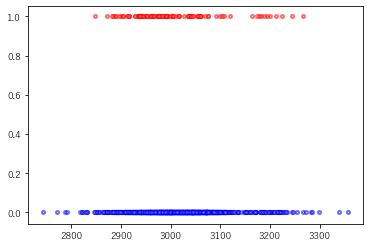

説明変数1の散布図


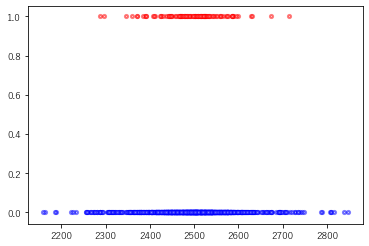

説明変数2の散布図


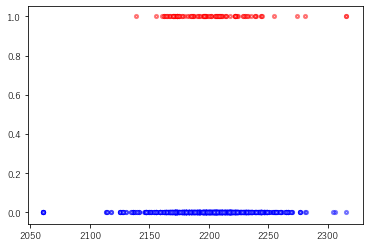

説明変数3の散布図


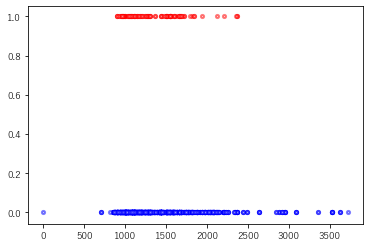

説明変数6の散布図


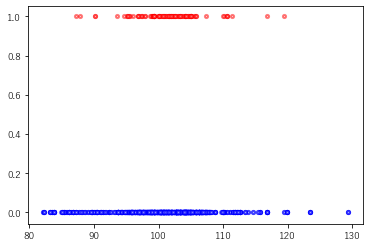

説明変数14の散布図


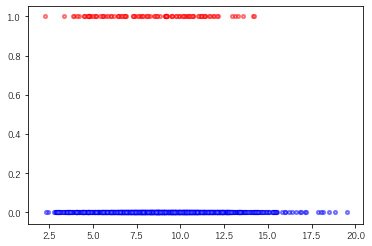

説明変数15の散布図


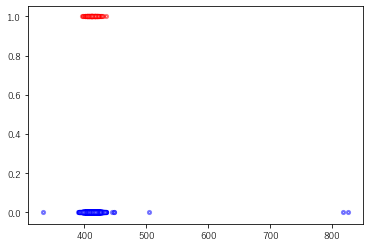

説明変数21の散布図


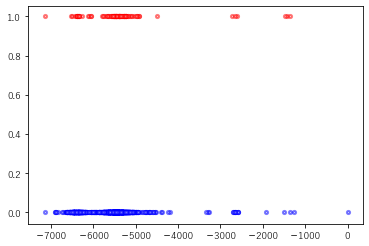

説明変数23の散布図


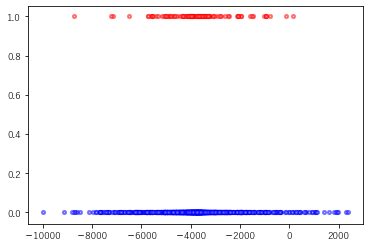

説明変数24の散布図


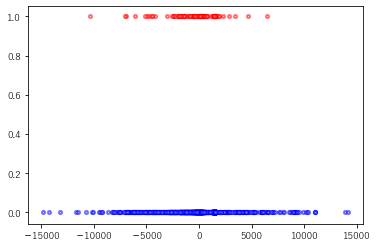

説明変数27の散布図


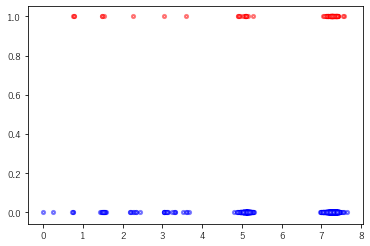

説明変数28の散布図


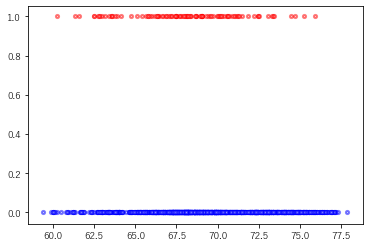

説明変数32の散布図


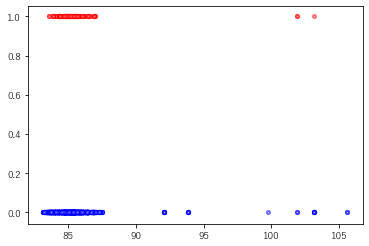

説明変数34の散布図


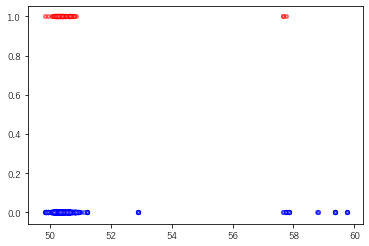

説明変数37の散布図


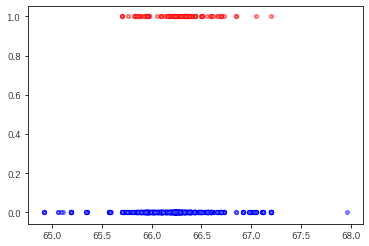

説明変数40の散布図


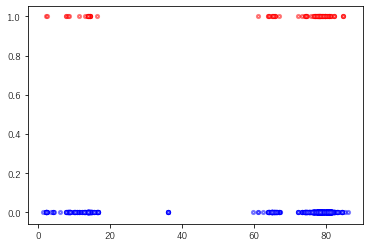

説明変数41の散布図


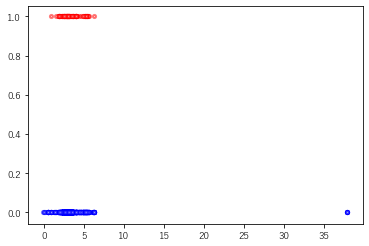

説明変数45の散布図


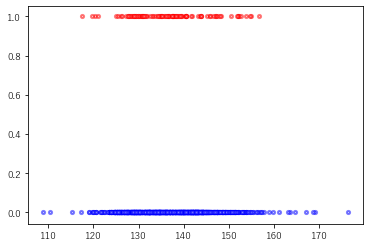

説明変数55の散布図


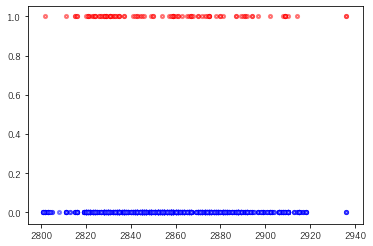

説明変数59の散布図


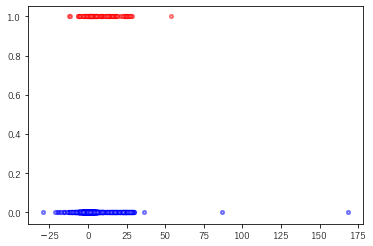

説明変数63の散布図


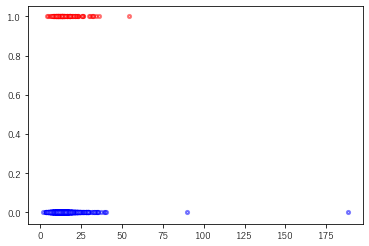

説明変数64の散布図


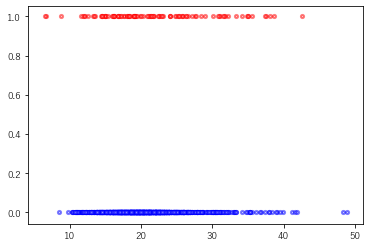

説明変数65の散布図


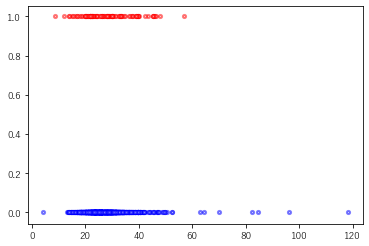

説明変数67の散布図


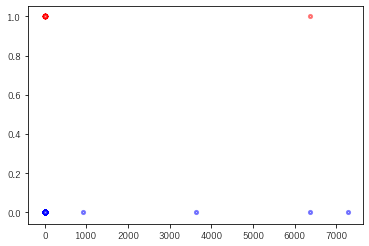

説明変数71の散布図


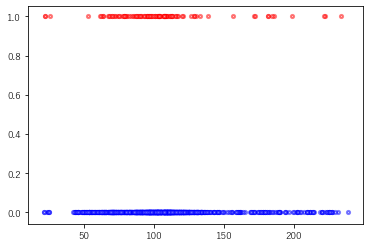

説明変数88の散布図


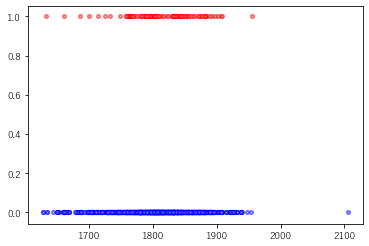

説明変数90の散布図


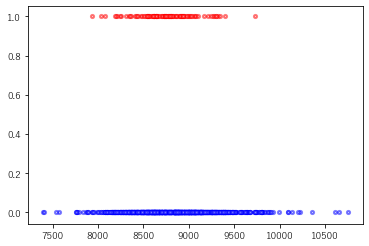

説明変数98の散布図


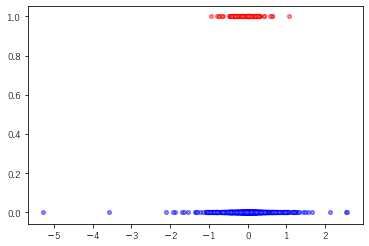

説明変数115の散布図


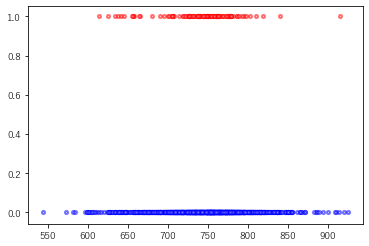

説明変数117の散布図


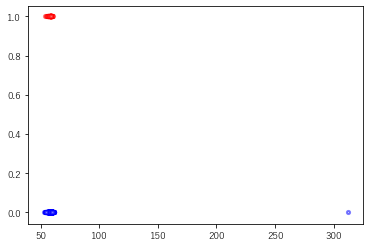

説明変数122の散布図


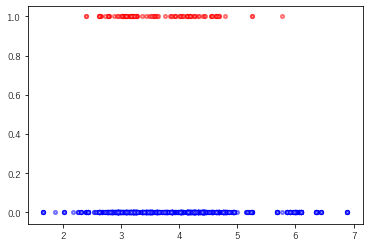

説明変数129の散布図


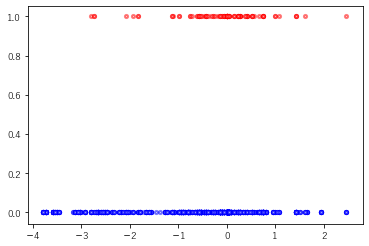

説明変数133の散布図


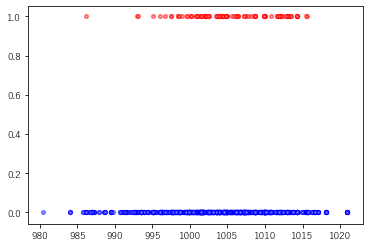

説明変数136の散布図


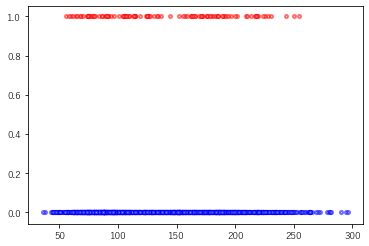

説明変数137の散布図


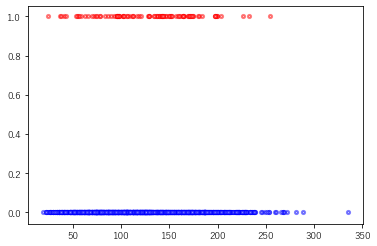

説明変数139の散布図


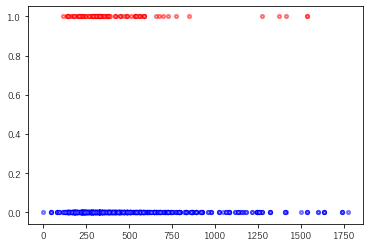

説明変数151の散布図


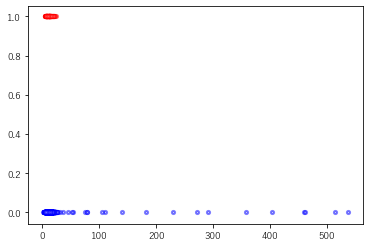

説明変数159の散布図


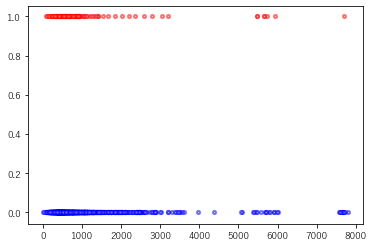

説明変数160の散布図


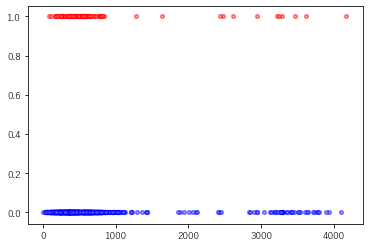

説明変数162の散布図


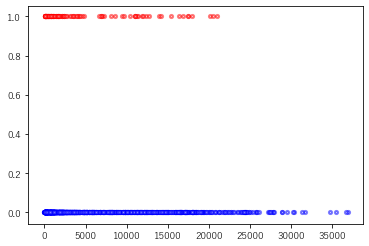

説明変数177の散布図


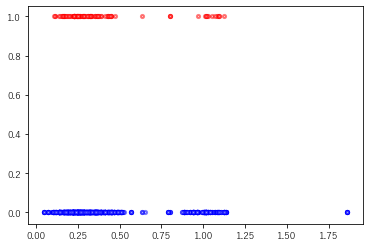

説明変数180の散布図


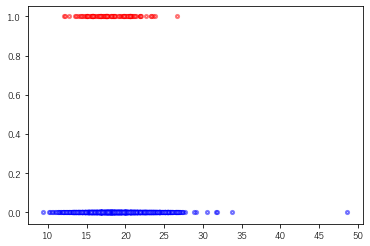

説明変数185の散布図


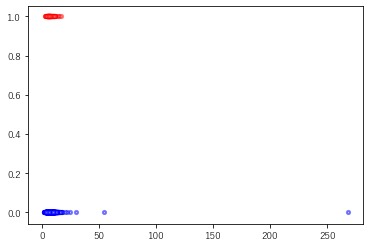

説明変数187の散布図


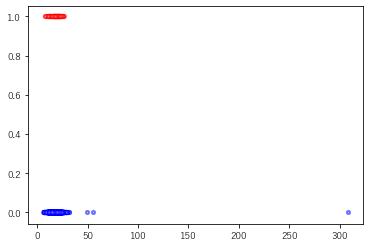

説明変数188の散布図


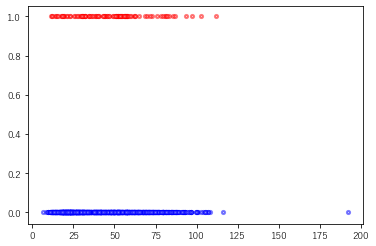

説明変数196の散布図


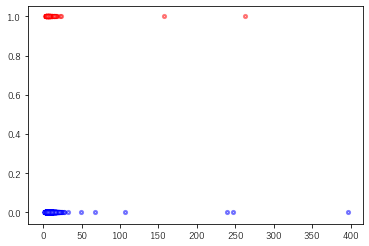

説明変数197の散布図


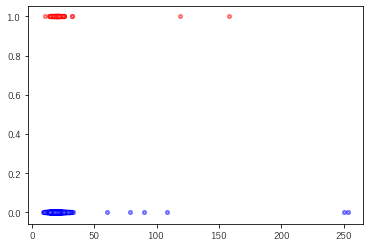

説明変数199の散布図


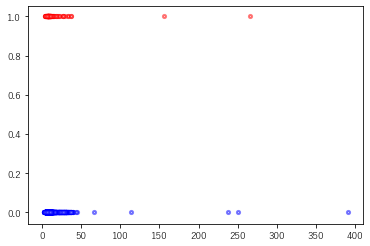

説明変数201の散布図


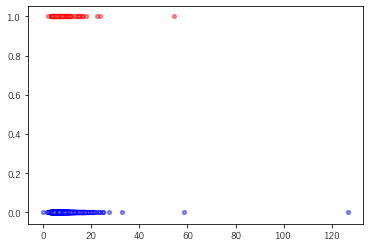

説明変数202の散布図


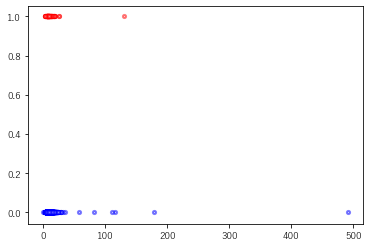

説明変数203の散布図


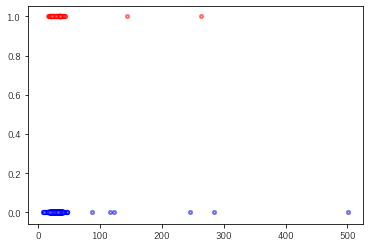

説明変数204の散布図


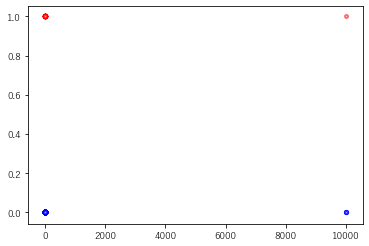

説明変数205の散布図


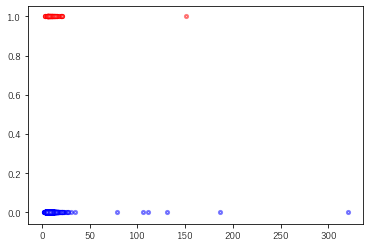

説明変数207の散布図


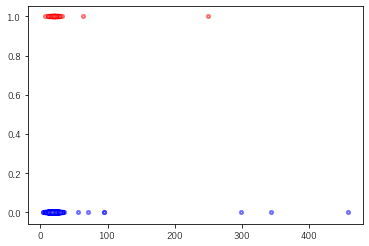

説明変数271の散布図


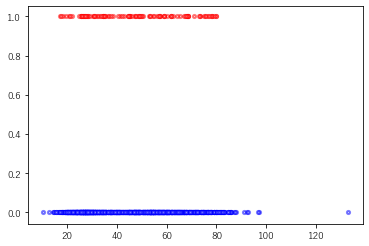

説明変数272の散布図


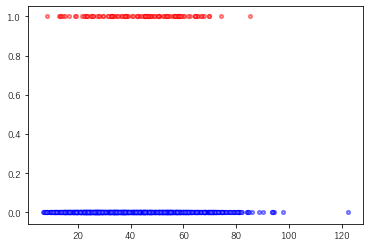

説明変数274の散布図


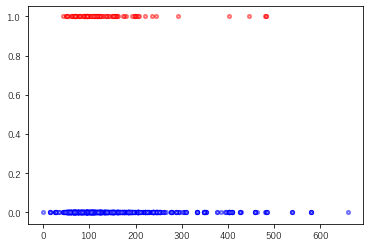

説明変数294の散布図


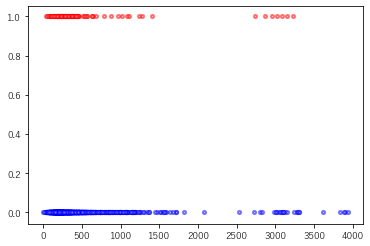

説明変数295の散布図


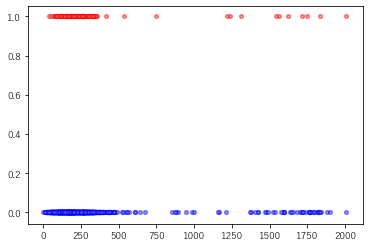

説明変数297の散布図


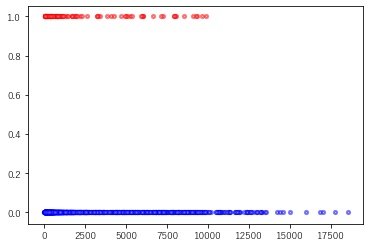

説明変数324の散布図


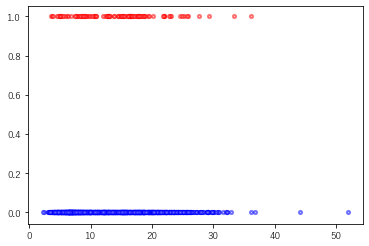

説明変数332の散布図


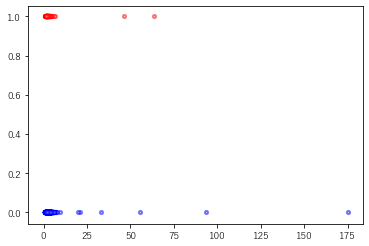

説明変数333の散布図


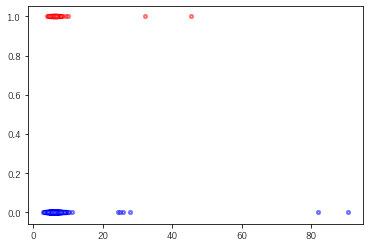

説明変数335の散布図


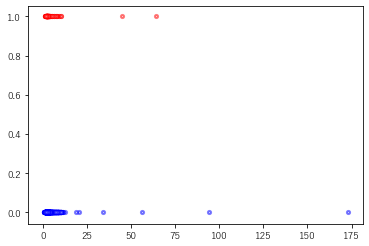

説明変数336の散布図


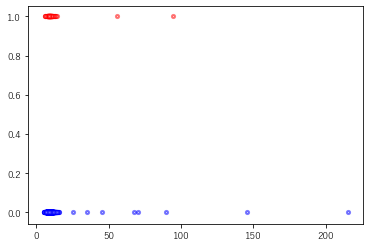

説明変数339の散布図


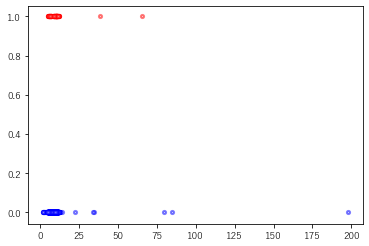

説明変数340の散布図


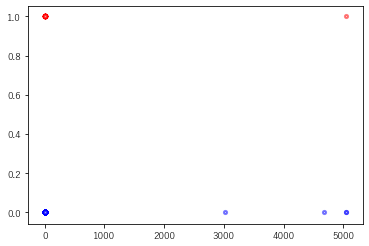

説明変数343の散布図


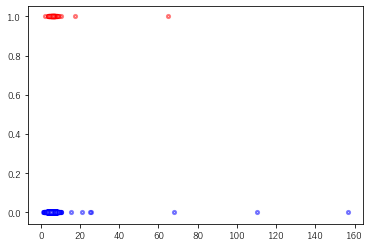

説明変数363の散布図


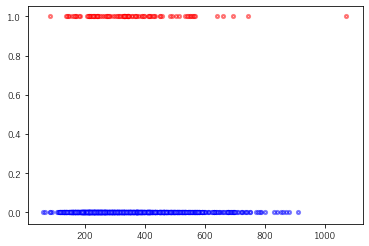

説明変数388の散布図


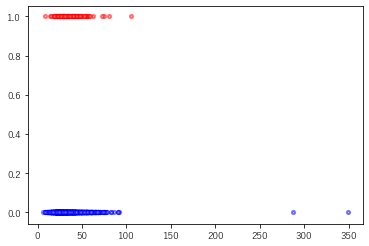

説明変数412の散布図


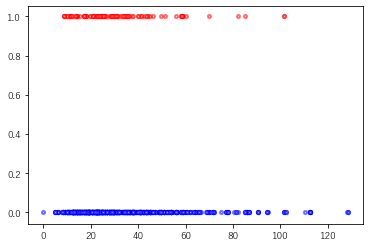

説明変数415の散布図


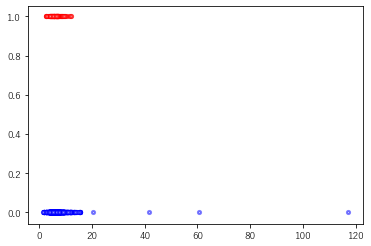

説明変数416の散布図


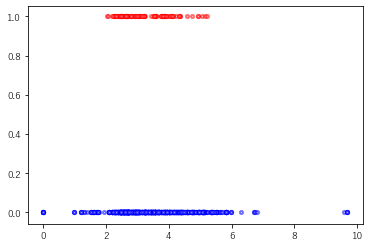

説明変数417の散布図


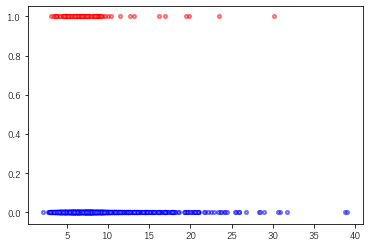

説明変数418の散布図


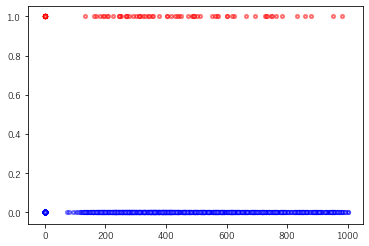

説明変数419の散布図


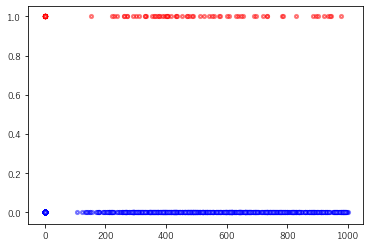

説明変数420の散布図


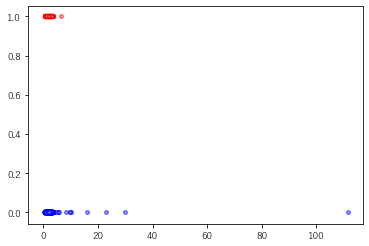

説明変数423の散布図


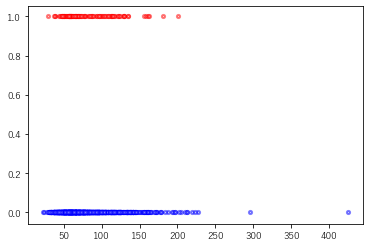

説明変数428の散布図


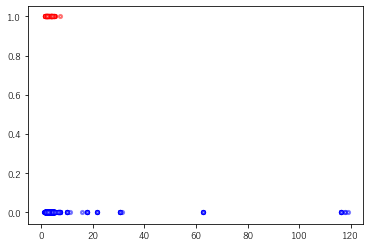

説明変数429の散布図


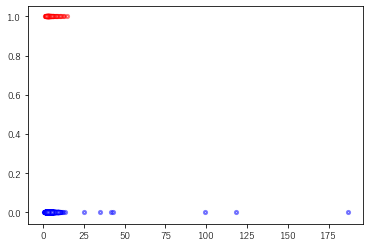

説明変数430の散布図


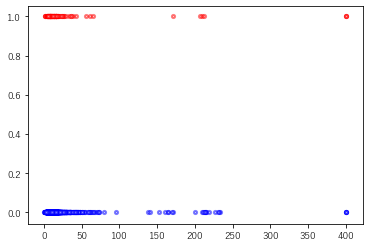

説明変数431の散布図


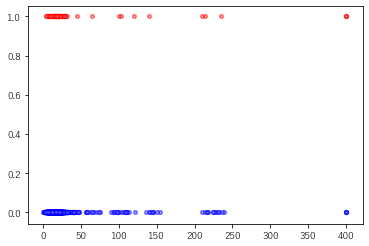

説明変数432の散布図


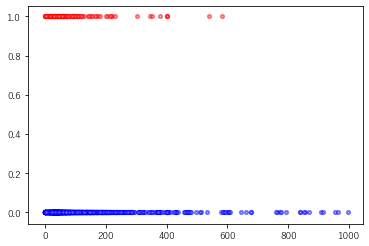

説明変数433の散布図


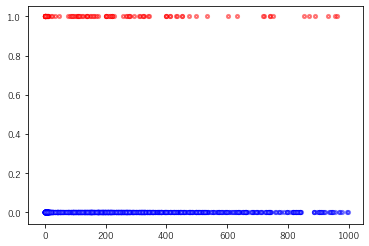

説明変数434の散布図


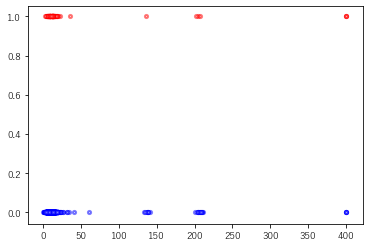

説明変数435の散布図


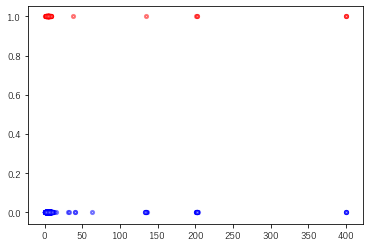

説明変数436の散布図


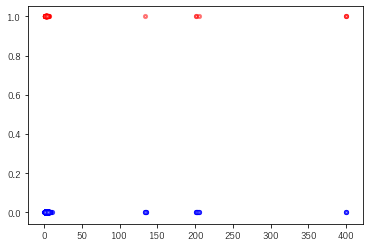

説明変数437の散布図


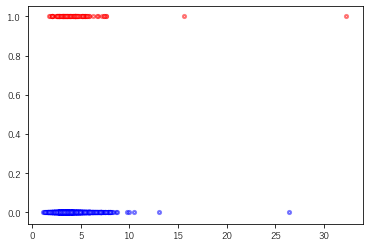

説明変数438の散布図


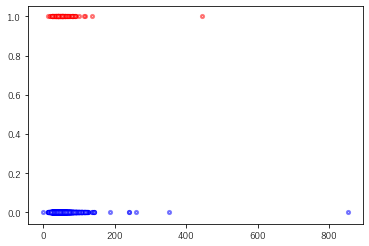

説明変数439の散布図


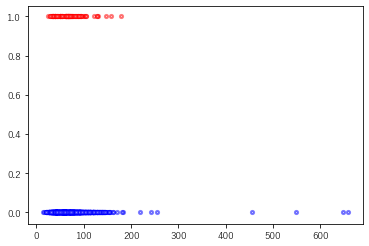

説明変数440の散布図


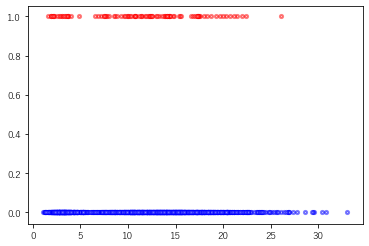

説明変数445の散布図


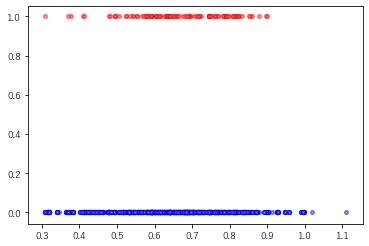

説明変数453の散布図


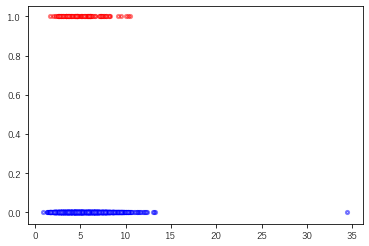

説明変数456の散布図


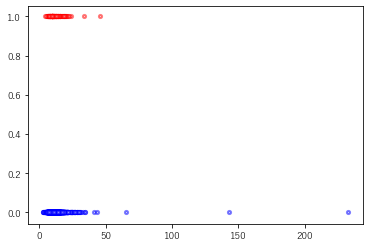

説明変数460の散布図


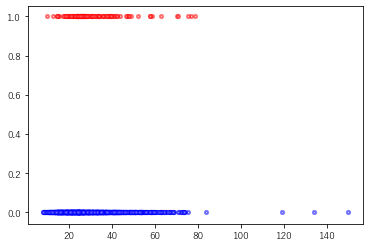

説明変数467の散布図


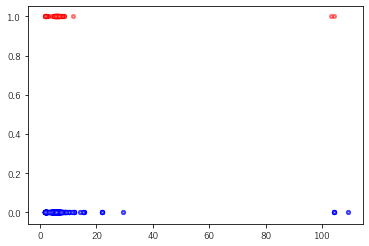

説明変数468の散布図


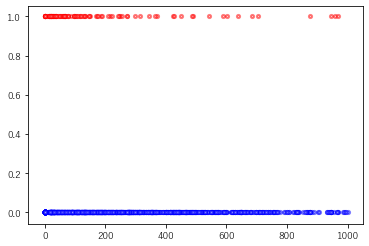

説明変数470の散布図


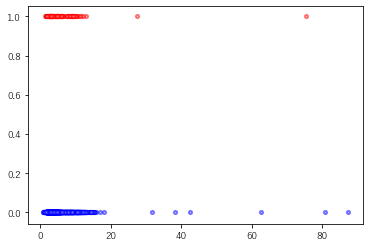

説明変数472の散布図


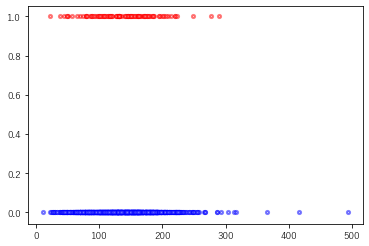

説明変数474の散布図


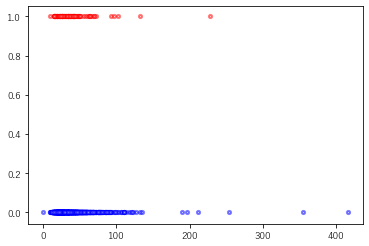

説明変数476の散布図


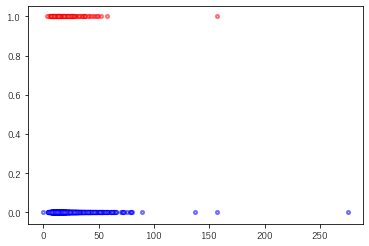

説明変数482の散布図


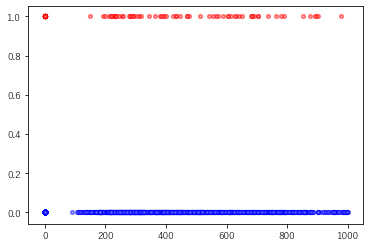

説明変数483の散布図


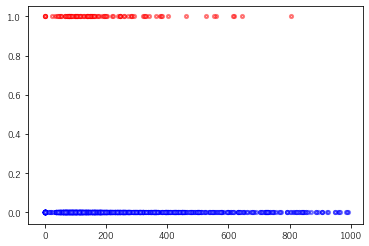

説明変数484の散布図


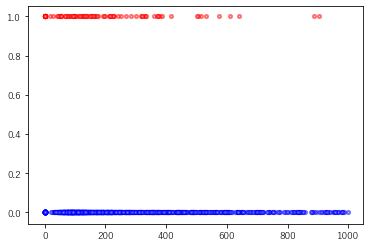

説明変数485の散布図


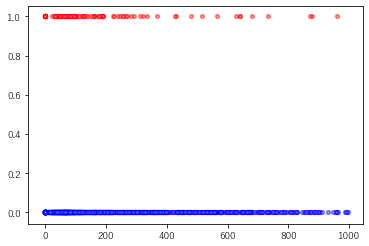

説明変数486の散布図


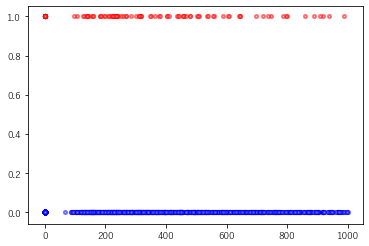

説明変数487の散布図


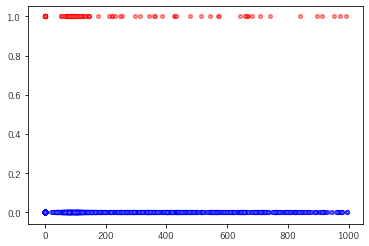

説明変数488の散布図


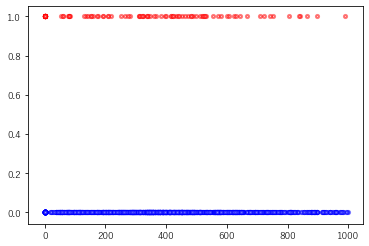

説明変数489の散布図


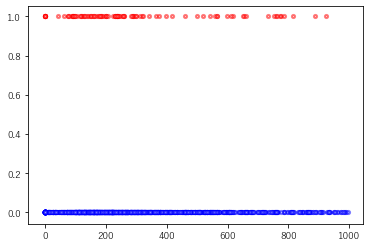

説明変数491の散布図


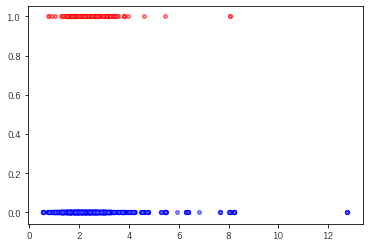

説明変数493の散布図


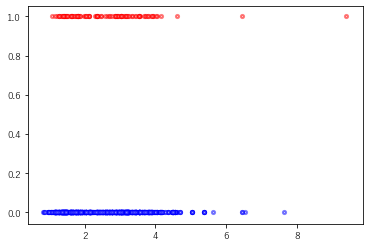

説明変数494の散布図


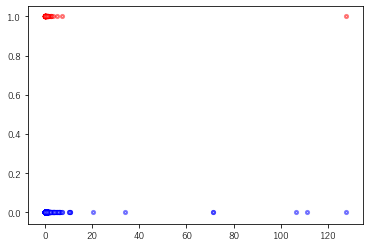

説明変数496の散布図


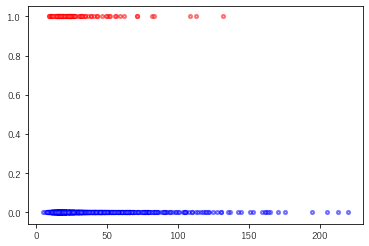

説明変数499の散布図


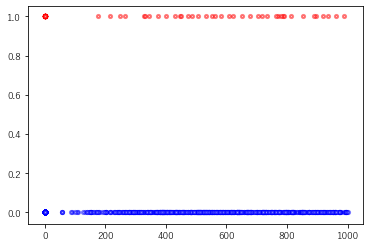

説明変数500の散布図


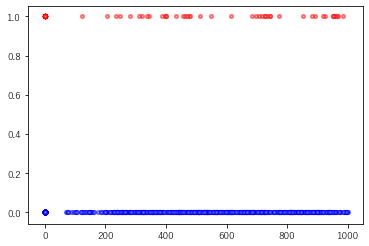

説明変数510の散布図


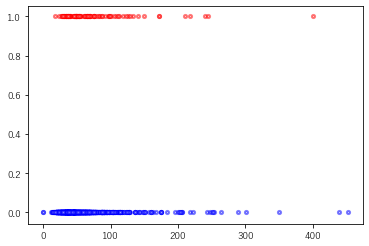

説明変数511の散布図


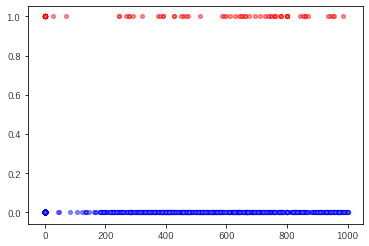

説明変数520の散布図


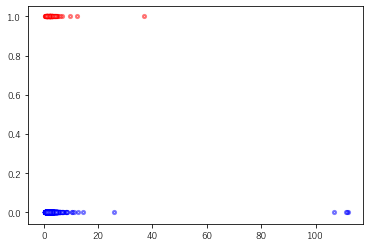

説明変数521の散布図


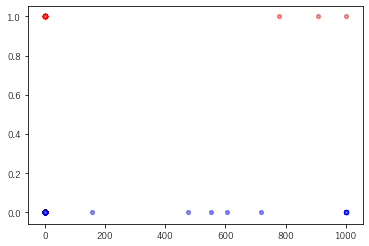

説明変数523の散布図


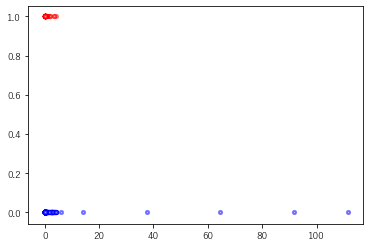

説明変数524の散布図


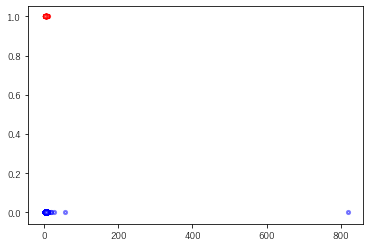

説明変数525の散布図


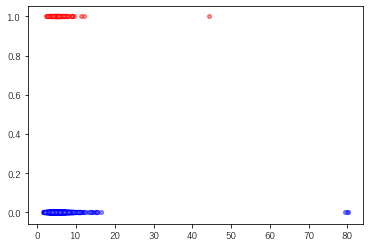

説明変数526の散布図


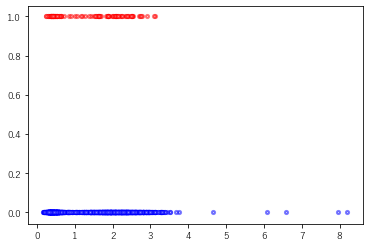

説明変数527の散布図


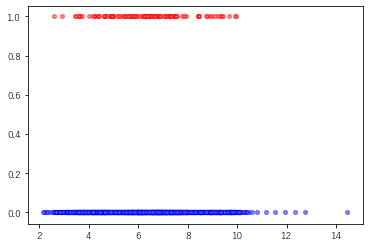

説明変数541の散布図


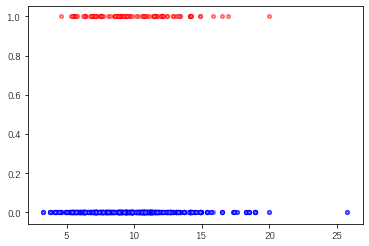

説明変数545の散布図


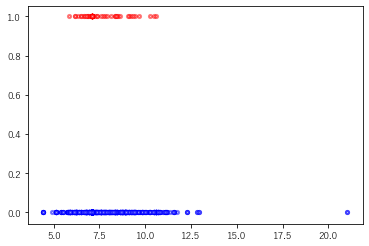

説明変数546の散布図


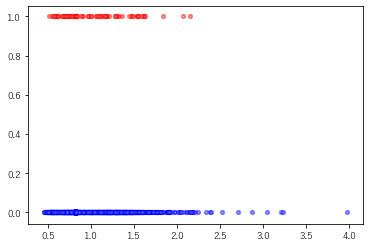

説明変数547の散布図


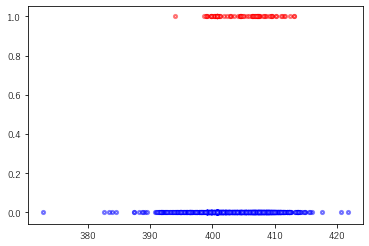

説明変数548の散布図


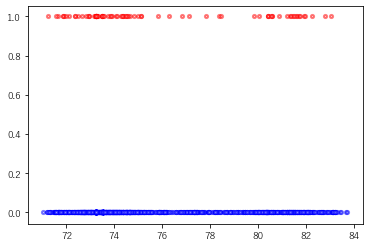

説明変数550の散布図


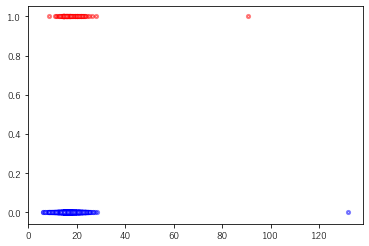

説明変数555の散布図


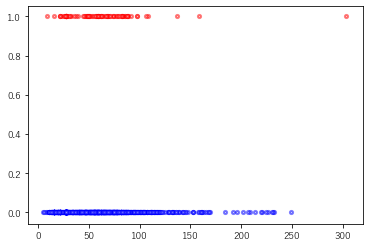

説明変数557の散布図


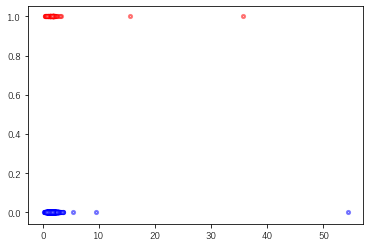

説明変数561の散布図


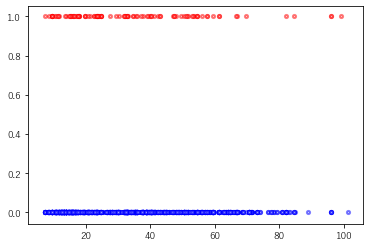

説明変数562の散布図


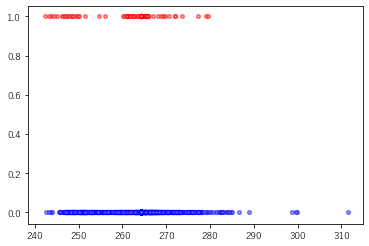

説明変数564の散布図


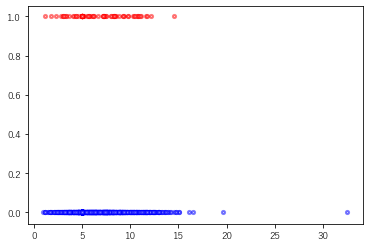

説明変数569の散布図


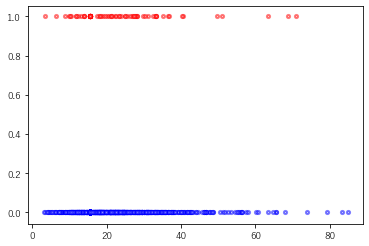

説明変数570の散布図


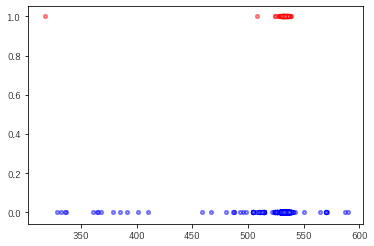

説明変数571の散布図


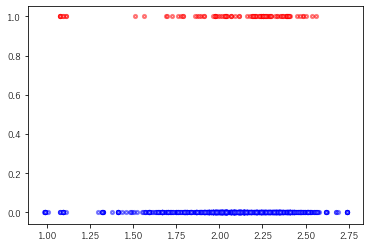

説明変数577の散布図


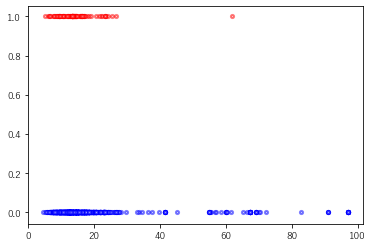

説明変数589の散布図


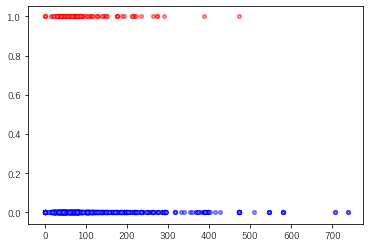

In [65]:
for i in x_train.columns:
    print(f'説明変数{i}の散布図')
    x1 = df[df['Pass/Fail'] == 0][i]
    y1 = df[df['Pass/Fail'] == 0]['Pass/Fail']
    x2 = df[df['Pass/Fail'] == 1][i]
    y2 = df[df['Pass/Fail'] == 1]['Pass/Fail']
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # x1, y1を青色でプロット
    ax.scatter(x1, y1, s=10, alpha=0.5, linewidths=2, c='#aaaaFF', edgecolors='b')
    # x2, y2を赤色でプロット
    ax.scatter(x2, y2, s=10, alpha=0.5, linewidths=2, c='#FFaaaa', edgecolors='r')
    plt.show()

# lightGBMを使用した特徴量の重要度を算出
https://mathmatical22.xyz/2020/04/12/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E5%90%91%E3%81%91%E3%80%91%E7%89%B9%E5%BE%B4%E9%87%8F%E9%87%8D%E8%A6%81%E5%BA%A6%E3%81%AE%E7%AE%97%E5%87%BA-lightgbm-%E3%80%90python%E3%80%91%E3%80%90%E6%A9%9F/

In [66]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',        # 目的 : 2クラス分類  
        'metric': {'binary_error'},   # 評価指標 : 誤り率(= 1-正答率) 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# 特徴量重要度の算出 (データフレームで取得)
cols = x_train.columns # 特徴量名のリスト(目的変数と欠損値以外)

f_importance = np.array(model.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance.query('importance == 0')) #重要度が低い(ない)変数
display(df_importance.query('importance > 0')) #重要度があるor高い変数

[LightGBM] [Info] Number of positive: 77, number of negative: 867
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33253
[LightGBM] [Info] Number of data points in the train set: 944, number of used features: 139
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081568 -> initscore=-2.421234
[LightGBM] [Info] Start training from score -2.421234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.0433387
[2]	valid_0's binary_error: 0.0433387
[3]	valid_0's binary_error: 0.0433387
[4]	valid_0's binary_error: 0.0433387
[5]	valid_0's binary_error: 0.0433387
[6]	valid_0's binary_error: 0.0433387
[7]	valid_0's binary_error: 0.0433387
[8]	valid_0's binary_error: 0.0433387
[9]	valid_0's binary_error: 0.0433387
[10]	valid_0's binary_error: 0.0433387
[11]	valid_0's binary_error: 0.0433387
[12]	valid_0'

feature  importance
118     521         0.0

feature  importance
19       59    0.057152
7        21    0.027406
29      117    0.021390
21       64    0.020053
13       34    0.017045
..      ...         ...
80      430    0.001337
113     499    0.001337
57      294    0.001003
56      274    0.000668
48      201    0.000334

[139 rows x 2 columns]

In [67]:
df_importance[0:10]

feature  importance
19       59    0.057152
7        21    0.027406
29      117    0.021390
21       64    0.020053
13       34    0.017045
30      122    0.016377
123     527    0.015374
117     520    0.014372
124     541    0.014372
91      445    0.013703

### lightGBMと相関の共通項「21」「59」「117」の特徴を確認する

In [68]:
pd.DataFrame(x_train.columns).to_csv('特徴量140個.csv',header=False, index=False)

In [69]:
def targethist(df, target, save=False, kind='hist', **kwards):
     
    columns = df.columns[df.columns != target]
    pdf = df.pivot_table(index=df.index, columns=target)
     
    for column in columns:
         
        ax = pdf.loc[:, column].plot(kind=kind, title=column, **kwards)
         
        if save==True:
            ax.get_figure().savefig(column+".png") 

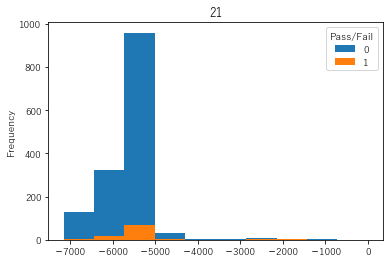

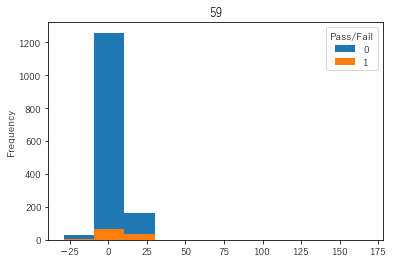

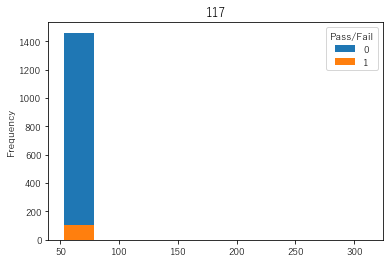

In [70]:
df_importance_features = df[['21','59','117','Pass/Fail']]
targethist(df_importance_features, target="Pass/Fail")

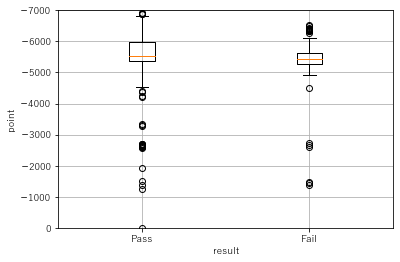

In [71]:
#21の箱ひげ図

# 合格
Pass = df_median[df_median['Pass/Fail'] == 0]['21']
# 不合格
Fail = df_median[df_median['Pass/Fail'] == 1]['21']
# 点数のタプル
points = (Pass, Fail)

# 箱ひげ図
fig, ax = plt.subplots()

bp = ax.boxplot(points)
ax.set_xticklabels(['Pass', 'Fail'])

# plt.title('Box plot')
plt.xlabel('result')
plt.ylabel('point')
# Y軸のメモリのrange
plt.ylim([0,-7000])
plt.grid()

# 描画
plt.show()

**Student(スチューデント)のt検定**<br/>
https://qiita.com/suaaa7/items/745ac1ca0a8d6753cf60

In [72]:
#対応しない2郡間の差の検定
A_var = np.var(Pass, ddof=1)  # Aの不偏分散
B_var = np.var(Fail, ddof=1)  # Bの不偏分散
A_df = len(Pass) - 1  # Aの自由度
B_df = len(Fail) - 1  # Bの自由度
f = A_var / B_var  # F比の値
one_sided_pval1 = stats.f.cdf(f, A_df, B_df)  # 片側検定のp値 1
one_sided_pval2 = stats.f.sf(f, A_df, B_df)   # 片側検定のp値 2
two_sided_pval = min(one_sided_pval1, one_sided_pval2) * 2  # 両側検定のp値

print('F:       ', round(f, 3))
print('p-value: ', round(two_sided_pval, 3))

F:        0.394
p-value:  0.0


**p < 0.05なので、帰無仮説は棄却され、2群間は等分散でないことが示唆されました。==t検定できない**

In [73]:
stats.ttest_ind(Pass, Fail)

Ttest_indResult(statistic=-4.3110509674094715, pvalue=1.7262018175376648e-05)

**p > 0.05なので、帰無仮説は棄却されず、2群間に差はないということが判断された**

In [74]:
stats.mannwhitneyu(Pass, Fail, alternative='two-sided')

MannwhitneyuResult(statistic=60476.0, pvalue=0.0004677744869412677)

**p > 0.05なので、帰無仮説は棄却されず、2群の代表値には差があるとはいえない。**

In [75]:
# #U検定の確認用　外れ値の影響を受けるか否か？
# df_median_59 = df_median.copy()
# df_median_59 = df_median_59.sort_values('59')
# df_median_59 = df_median_59.replace({'59': {168.1455: 10000}})

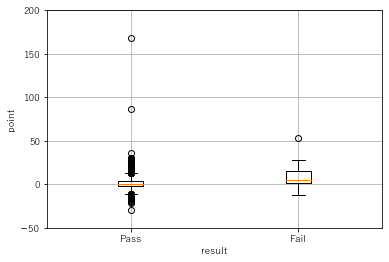

In [76]:
#59の箱ひげ図

# 合格
Pass = df_median[df_median['Pass/Fail'] == 0]['59']
# 不合格
Fail = df_median[df_median['Pass/Fail'] == 1]['59']
# 点数のタプル
points = (Pass, Fail)

# 箱ひげ図
fig, ax = plt.subplots()

bp = ax.boxplot(points)
ax.set_xticklabels(['Pass', 'Fail'])

# plt.title('Box plot')
plt.xlabel('result')
plt.ylabel('point')
# Y軸のメモリのrange
plt.ylim([-50,200])
plt.grid()

# 描画
plt.show()

In [77]:
#対応しない2郡間の差の検定
A_var = np.var(Pass, ddof=1)  # Aの不偏分散
B_var = np.var(Fail, ddof=1)  # Bの不偏分散
A_df = len(Pass) - 1  # Aの自由度
B_df = len(Fail) - 1  # Bの自由度
f = A_var / B_var  # F比の値
one_sided_pval1 = stats.f.cdf(f, A_df, B_df)  # 片側検定のp値 1
one_sided_pval2 = stats.f.sf(f, A_df, B_df)   # 片側検定のp値 2
two_sided_pval = min(one_sided_pval1, one_sided_pval2) * 2  # 両側検定のp値

print('F:       ', round(f, 3))
print('p-value: ', round(two_sided_pval, 3))

F:        0.74
p-value:  0.026


**p < 0.05なので、帰無仮説は棄却され、2群間は等分散でないことが示唆されました。==t検定できない**

In [78]:
stats.ttest_ind(Pass, Fail)

Ttest_indResult(statistic=-6.248179059779337, pvalue=5.341075812328353e-10)

**p > 0.05なので、帰無仮説は棄却されず、2群間に差はないということが判断された**

In [79]:
stats.mannwhitneyu(Pass, Fail, alternative='two-sided')

MannwhitneyuResult(statistic=46800.5, pvalue=5.181700678990719e-11)

**p < 0.05なので、帰無仮説は棄却され、2群の代表値には差があるといえます。**

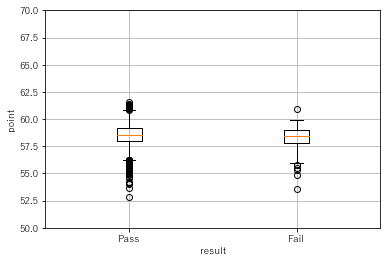

In [80]:
#117の箱ひげ図

# 合格
Pass = df_median[df_median['Pass/Fail'] == 0]['117']
# 不合格
Fail = df_median[df_median['Pass/Fail'] == 1]['117']
# 点数のタプル
points = (Pass, Fail)

# 箱ひげ図
fig, ax = plt.subplots()

bp = ax.boxplot(points)
ax.set_xticklabels(['Pass', 'Fail'])

# plt.title('Box plot')
plt.xlabel('result')
plt.ylabel('point')
# Y軸のメモリのrange
plt.ylim([50,70])
plt.grid()

# 描画
plt.show()

In [81]:
#対応しない2郡間の差の検定
A_var = np.var(Pass, ddof=1)  # Aの不偏分散
B_var = np.var(Fail, ddof=1)  # Bの不偏分散
A_df = len(Pass) - 1  # Aの自由度
B_df = len(Fail) - 1  # Bの自由度
f = A_var / B_var  # F比の値
one_sided_pval1 = stats.f.cdf(f, A_df, B_df)  # 片側検定のp値 1
one_sided_pval2 = stats.f.sf(f, A_df, B_df)   # 片側検定のp値 2
two_sided_pval = min(one_sided_pval1, one_sided_pval2) * 2  # 両側検定のp値

print('F:       ', round(f, 3))
print('p-value: ', round(two_sided_pval, 3))

F:        32.767
p-value:  0.0


**p < 0.05なので、帰無仮説は棄却され、2群間は等分散でないことが示唆されました。==t検定できない**

In [82]:
stats.ttest_ind(Pass, Fail)

Ttest_indResult(statistic=0.661533383662766, pvalue=0.5083676959729502)

**p > 0.05なので、帰無仮説は棄却されず、2群間に差があるとはいえないということが判断された**

In [83]:
stats.mannwhitneyu(Pass, Fail, alternative='two-sided')

MannwhitneyuResult(statistic=84467.5, pvalue=0.05985197566461026)

**p > 0.05なので、帰無仮説は棄却されず、2群の代表値には差があるとはいえない。**

In [84]:
df_median['59']

0       16.4582
1        9.0500
2       18.8309
3       18.2809
4       19.8000
         ...   
1562     1.2518
1563     0.0064
1564     2.1927
1565     3.6664
1566     1.4845
Name: 59, Length: 1567, dtype: float64

### 2変量間の散布図作成

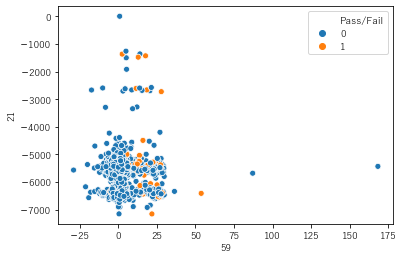

In [85]:
# 59と21の関係性
x = df_median['59']
y = df_median['21']
 
# 散布図を描画
sns.scatterplot(x,y,hue=df_median['Pass/Fail'])

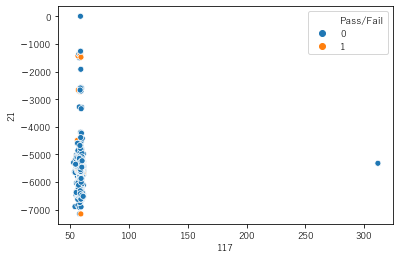

In [86]:
# 117と21の関係性
x = df_median['117']
y = df_median['21']
 
# 散布図を描画
sns.scatterplot(x,y,hue=df_median['Pass/Fail'])

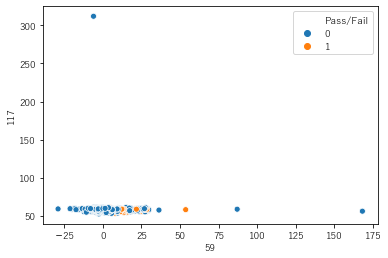

In [87]:
# 50と117の関係性
x = df_median['59']
y = df_median['117']
 
# 散布図を描画
sns.scatterplot(x,y,hue=df_median['Pass/Fail'])

### 「59」「21」「117」の時系列ごとの可視化

In [115]:
#月のデータ抽出
df_median["Month"] = pd.to_datetime(df_median["Time"]).dt.strftime("%Y-%m")
df_median["Hour"] = pd.to_datetime(df_median["Time"]).dt.strftime("%H")

59の散布図


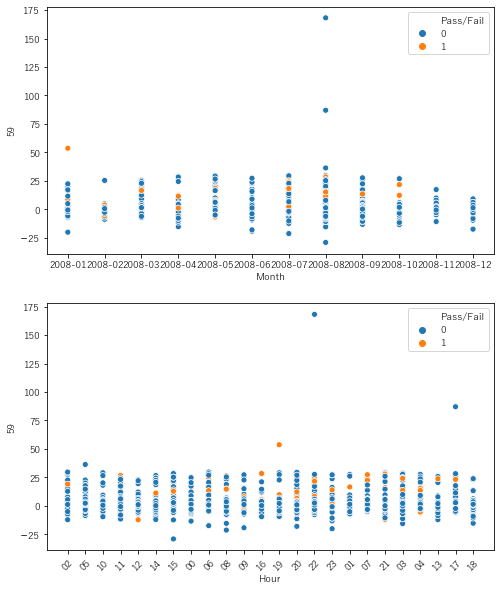

21の散布図


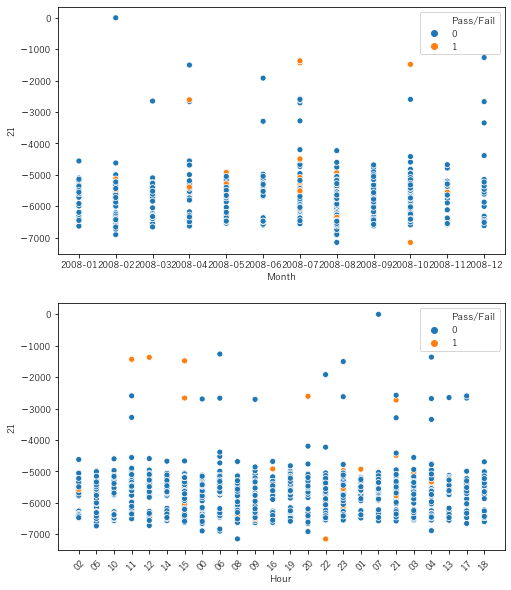

117の散布図


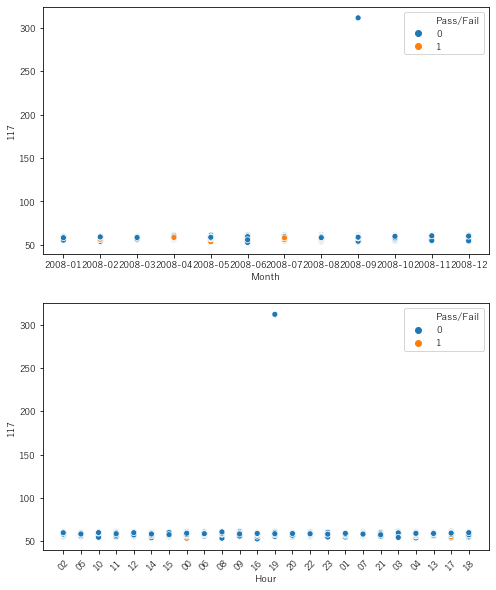

In [120]:
list = ['59','21','117']
for i in list:
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,10))
    print(f'{i}の散布図')
    sns.scatterplot(data=df_median , x='Month' ,y=i ,hue=df['Pass/Fail'],ax=ax1)
    sns.scatterplot(data=df_median , x='Hour' ,y=i ,hue=df['Pass/Fail'],ax=ax2)
    plt.xticks(rotation=45)
    plt.show()

### 相関上位10個,特徴量の重要度上位10個の時系列ごとの可視化


21の散布図


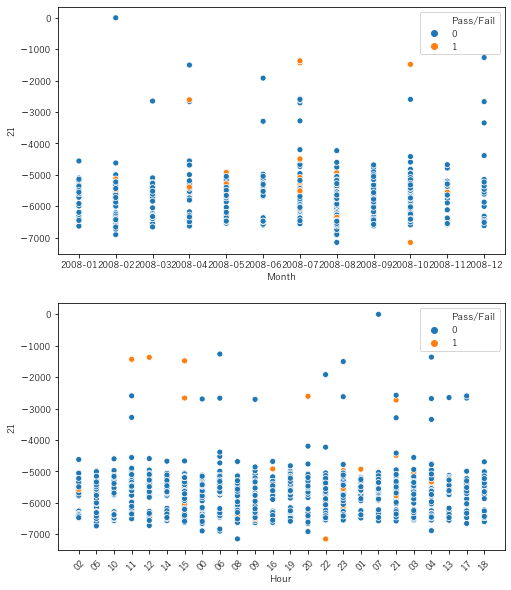


59の散布図


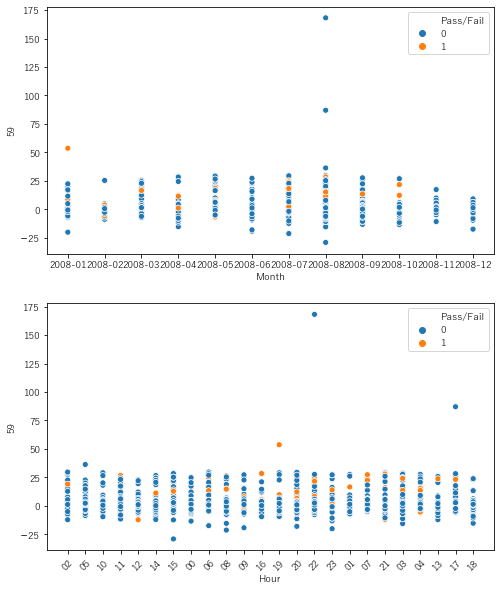


117の散布図


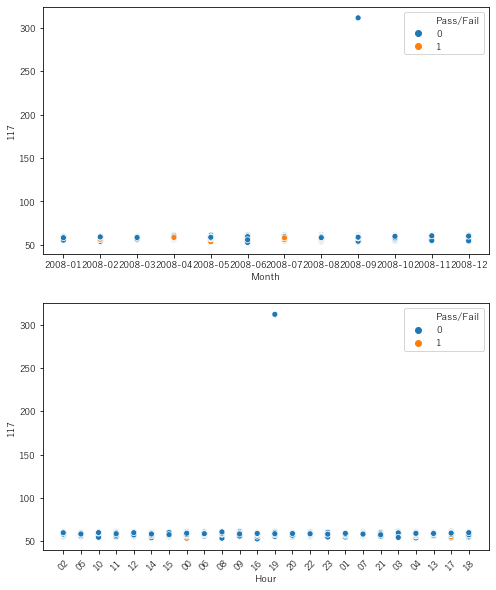


431の散布図


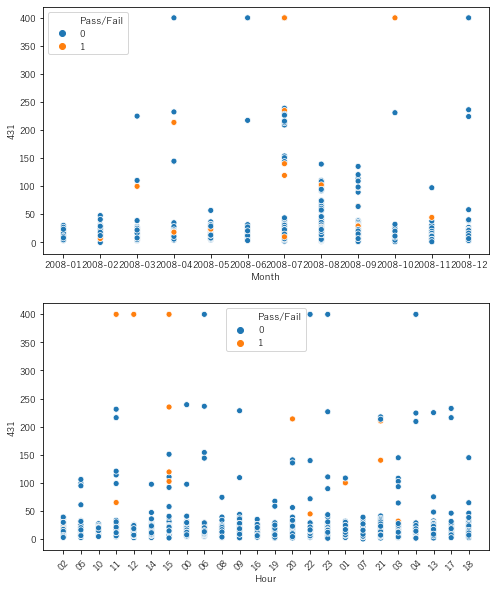


510の散布図


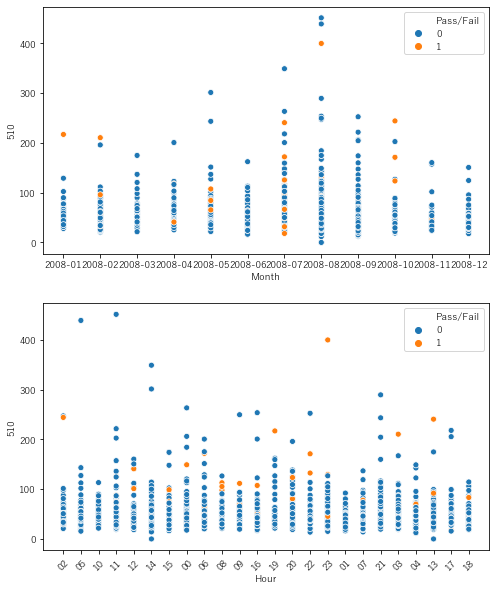


434の散布図


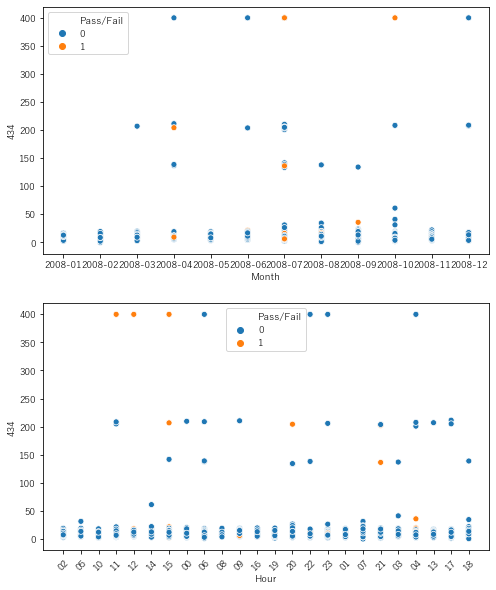


430の散布図


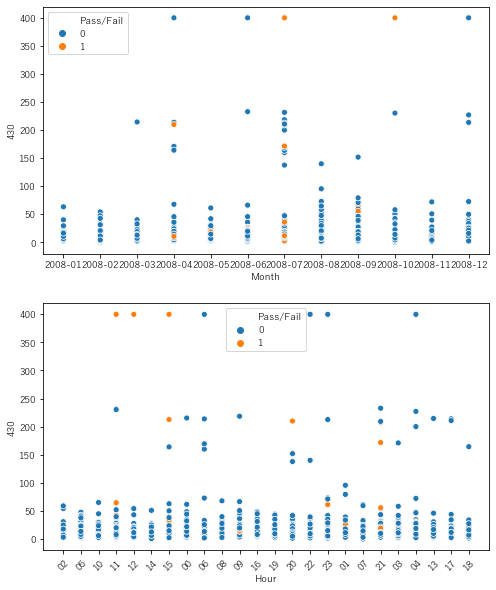


435の散布図


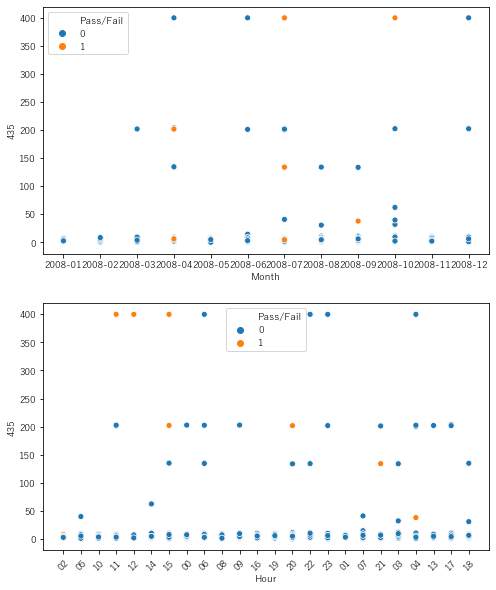


436の散布図


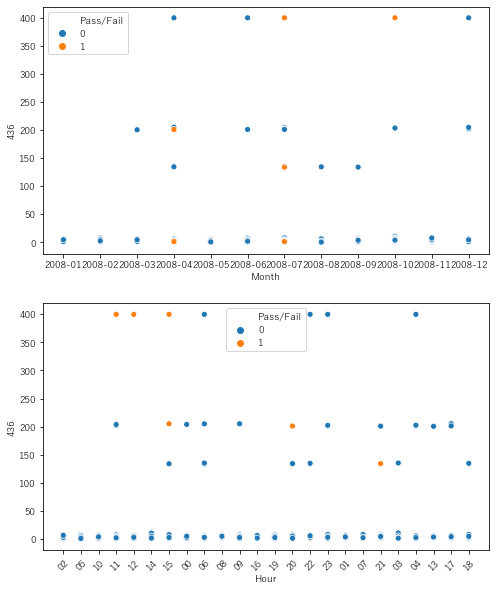


527の散布図


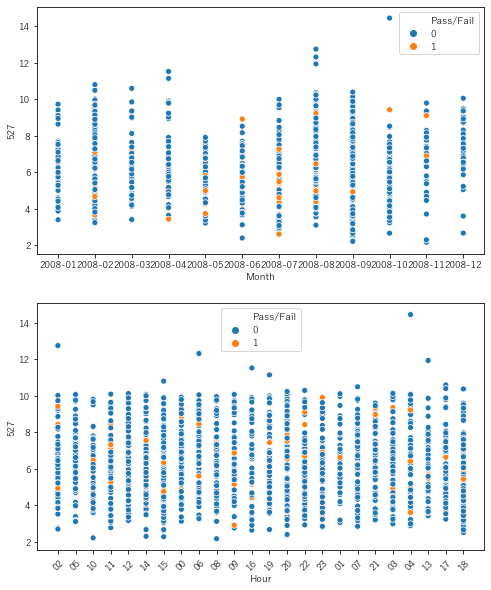

In [123]:
#相関上位10個
for i in corr[0:10].index:
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,10))
    print(f'\n{i}の散布図')
    sns.scatterplot(data=df_median , x='Month' ,y=i ,hue=df['Pass/Fail'],ax=ax1)
    sns.scatterplot(data=df_median , x='Hour' ,y=i ,hue=df['Pass/Fail'],ax=ax2)
    plt.xticks(rotation=45)
    plt.show()


59の散布図


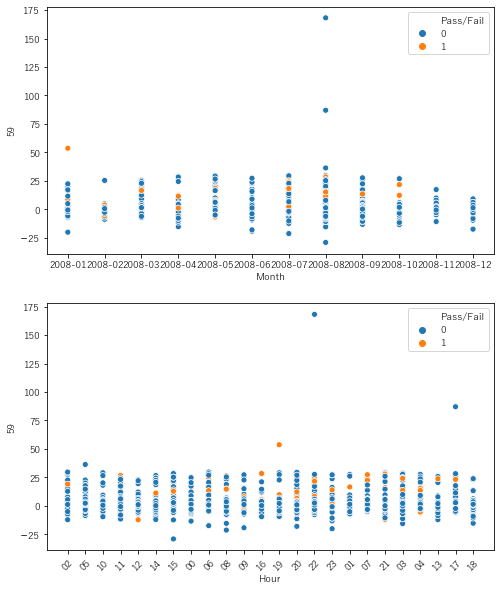


21の散布図


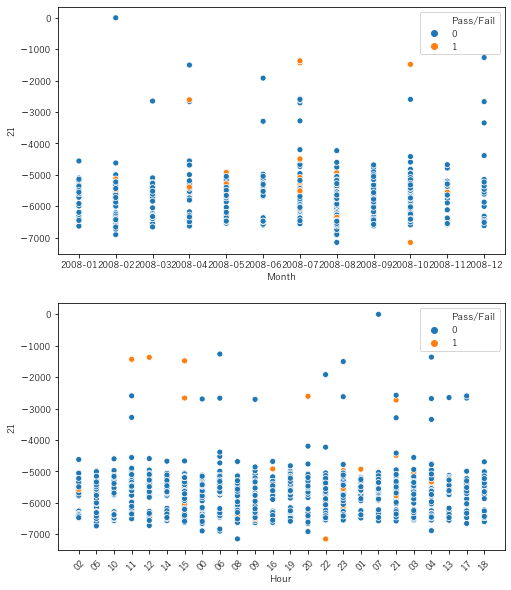


117の散布図


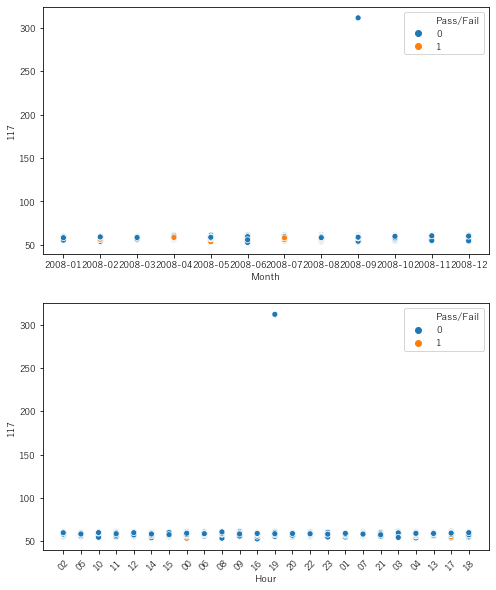


64の散布図


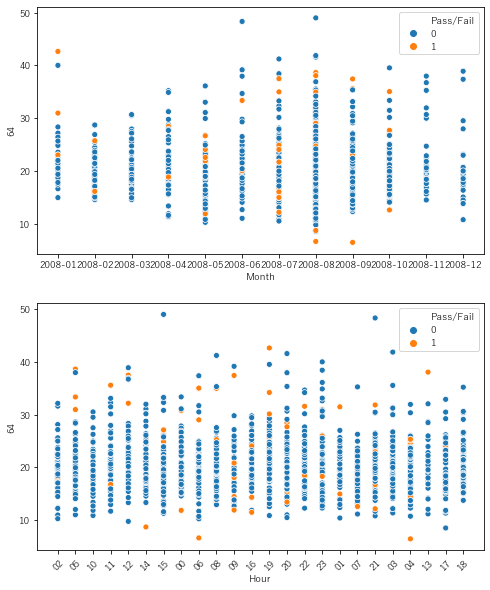


34の散布図


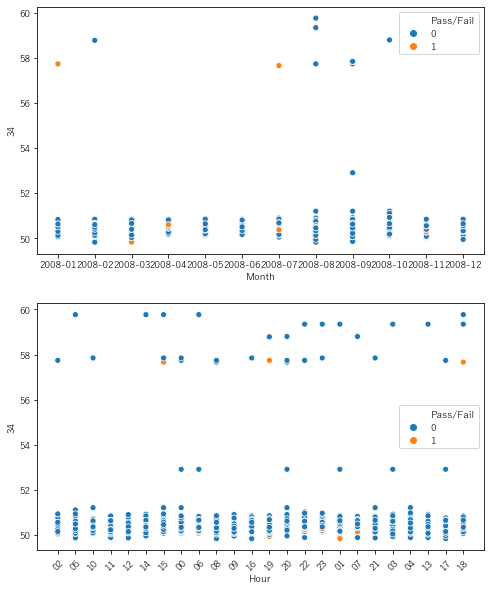


122の散布図


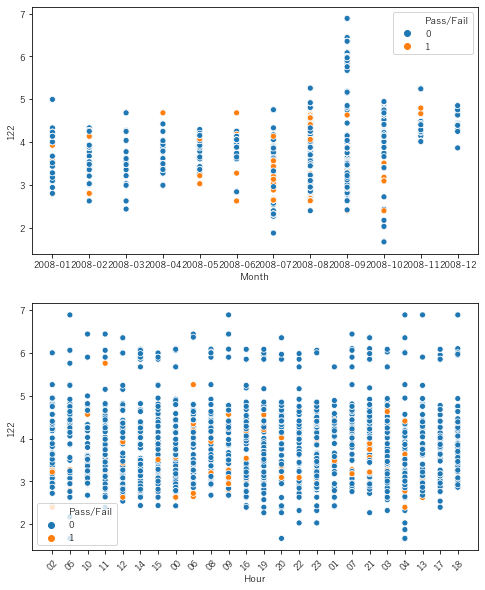


527の散布図


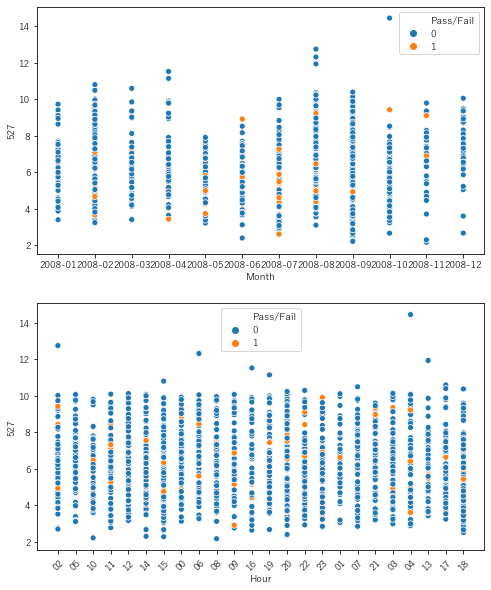


520の散布図


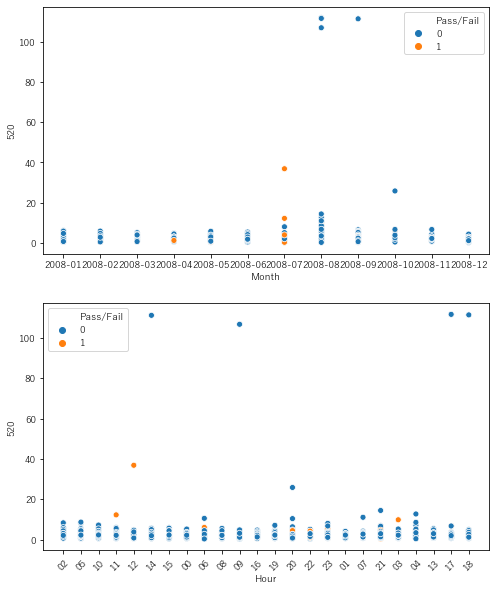


541の散布図


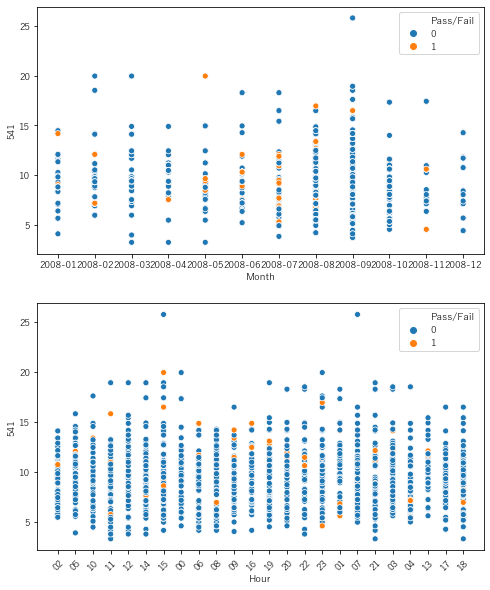


445の散布図


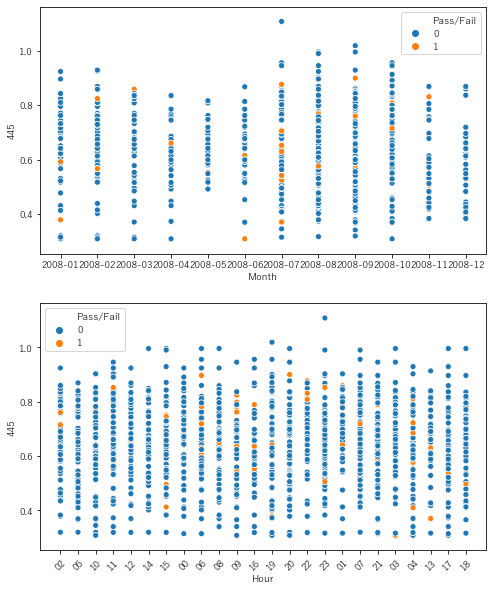

In [128]:
#特徴量の重要度上位10個
for i in df_importance[0:10]['feature']:
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,10))
    print(f'\n{i}の散布図')
    sns.scatterplot(data=df_median , x='Month' ,y=i ,hue=df['Pass/Fail'],ax=ax1)
    sns.scatterplot(data=df_median , x='Hour' ,y=i ,hue=df['Pass/Fail'],ax=ax2)
    plt.xticks(rotation=45)
    plt.show()

### 各変数における時系列の特徴は見受けられない

### 目的変数を予測するために使用される説明変数の傾向を把握するため、散布図で可視化

In [88]:
# for i in x_train.columns:
#     print(f'説明変数{i}の散布図')
#     x1 = df[df['Pass/Fail'] == 0][i]
#     y1 = df[df['Pass/Fail'] == 0]['Pass/Fail']
#     x2 = df[df['Pass/Fail'] == 1][i]
#     y2 = df[df['Pass/Fail'] == 1]['Pass/Fail']
#     fig = plt.figure()
#     ax = fig.add_subplot(1, 1, 1)

#     # x1, y1を青色でプロット
#     ax.scatter(x1, y1, s=10, alpha=0.5, linewidths=2, c='#aaaaFF', edgecolors='b')
#     # x2, y2を赤色でプロット
#     ax.scatter(x2, y2, s=10, alpha=0.5, linewidths=2, c='#FFaaaa', edgecolors='r')
#     plt.show()

## 重要な変数を抜いた場合のLasso
これで精度が下がれば、重要な変数は最も影響が大きいと判断できる

In [93]:
x_train_not_feature_importance = x_train.copy()
x_test_not_feature_importance = x_test.copy()

In [94]:
#相関が高かった上位10種類を除いたlasso
x_train_not_feature_importance = x_train_not_feature_importance.drop(corr['abs'][0:10].index,axis=1)
x_test_not_feature_importance = x_test_not_feature_importance.drop(corr['abs'][0:10].index,axis=1)

In [95]:
x_train_not_feature_importance.columns

Index(['0', '1', '2', '3', '6', '14', '15', '23', '24', '27',
       ...
       '555', '557', '561', '562', '564', '569', '570', '571', '577', '589'],
      dtype='object', length=130)

Lasso alpha=0.0001
Cross-Validation scores: [0.92063492 0.92063492 0.91534392 0.91534392 0.92021277]
Average score: 0.918
使用された特徴量の数: 5

Lasso回帰
auc:0.559


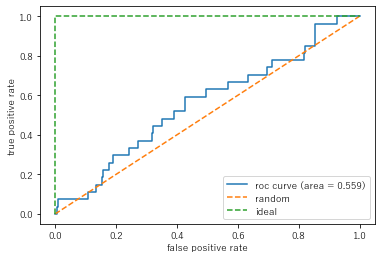

Lasso alpha=0.001
Cross-Validation scores: [0.92063492 0.92063492 0.91534392 0.8994709  0.92021277]
Average score: 0.915
使用された特徴量の数: 21

Lasso回帰
auc:0.564


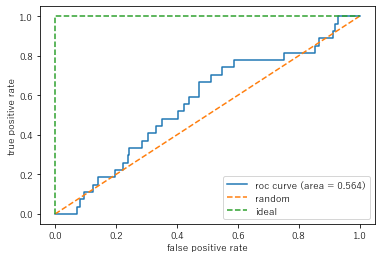

Lasso alpha=0.01
Cross-Validation scores: [0.92063492 0.91534392 0.89417989 0.88888889 0.91489362]
Average score: 0.907
使用された特徴量の数: 54

Lasso回帰
auc:0.543


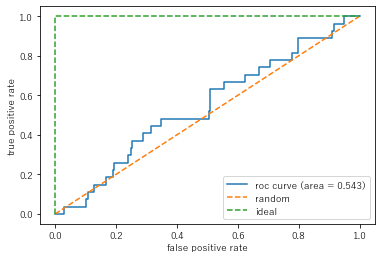

Lasso alpha=0.1
Cross-Validation scores: [0.91534392 0.87830688 0.85185185 0.87830688 0.88829787]
Average score: 0.882
使用された特徴量の数: 96

Lasso回帰
auc:0.616


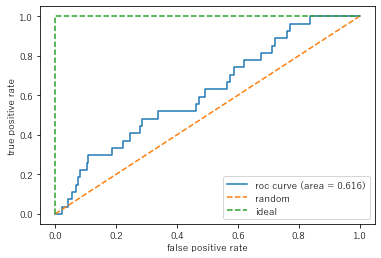

Lasso alpha=1.0
Cross-Validation scores: [0.8994709  0.8994709  0.83068783 0.83068783 0.87765957]
Average score: 0.868
使用された特徴量の数: 128

Lasso回帰
auc:0.707


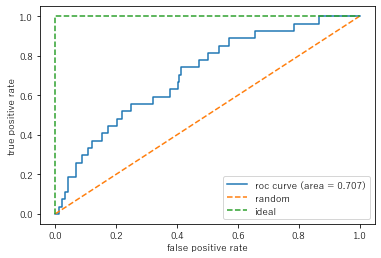

Lasso alpha=10.0
Cross-Validation scores: [0.88888889 0.8994709  0.75132275 0.8042328  0.86702128]
Average score: 0.842
使用された特徴量の数: 130

Lasso回帰
auc:0.717


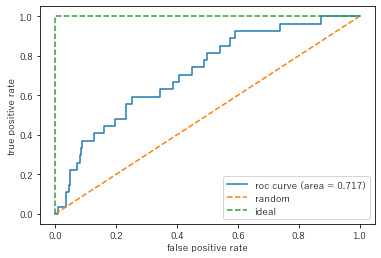

Lasso alpha=100.0
Cross-Validation scores: [0.88888889 0.88888889 0.74074074 0.7989418  0.86702128]
Average score: 0.837
使用された特徴量の数: 130

Lasso回帰
auc:0.717


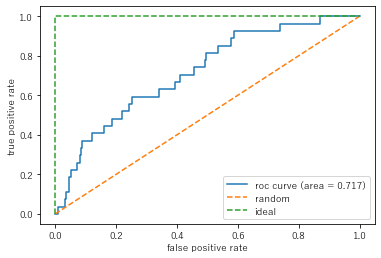

In [96]:
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_not_feature_importance,y_train)
    predict_lasso = clf_lasso.predict(x_test_not_feature_importance)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_not_feature_importance)
    
    print(f'Lasso alpha={alpha}')
    scores = cross_val_score(clf_lasso, x_train_not_feature_importance, y_train,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア
    
    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')
    
    Y_score = clf_lasso.predict_proba(x_test_not_feature_importance)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()


In [97]:
#lightgbmで特徴量の重要度が高かった上位10種類を除いたlasso
x_train_not_feature_importance = x_train.copy()
x_test_not_feature_importance = x_test.copy()

x_train_not_feature_importance = x_train_not_feature_importance.drop(corr_lightgbm_ls,axis=1)
x_test_not_feature_importance = x_test_not_feature_importance.drop(corr_lightgbm_ls,axis=1)

In [98]:
x_train_not_feature_importance.shape, x_test_not_feature_importance.shape

((944, 130), (623, 130))

Lasso alpha=0.0001
Cross-Validation scores: [0.92063492 0.92063492 0.91534392 0.91534392 0.92021277]
Average score: 0.918
使用された特徴量の数: 5

Lasso回帰
auc:0.559


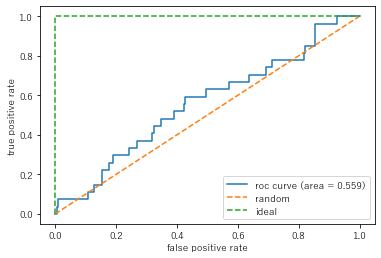

Lasso alpha=0.001
Cross-Validation scores: [0.92063492 0.92063492 0.91534392 0.8994709  0.92021277]
Average score: 0.915
使用された特徴量の数: 22

Lasso回帰
auc:0.566


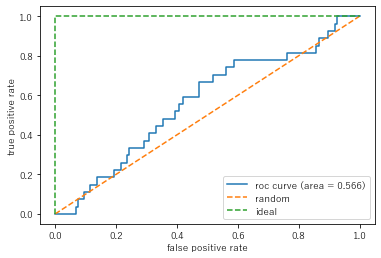

Lasso alpha=0.01
Cross-Validation scores: [0.92063492 0.91534392 0.8994709  0.88359788 0.91489362]
Average score: 0.907
使用された特徴量の数: 55

Lasso回帰
auc:0.574


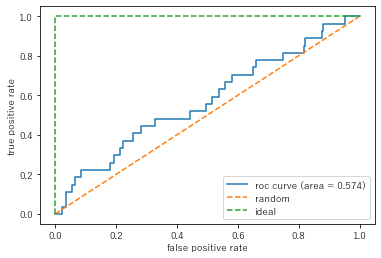

Lasso alpha=0.1
Cross-Validation scores: [0.91005291 0.87830688 0.85185185 0.86772487 0.89893617]
Average score: 0.881
使用された特徴量の数: 98

Lasso回帰
auc:0.620


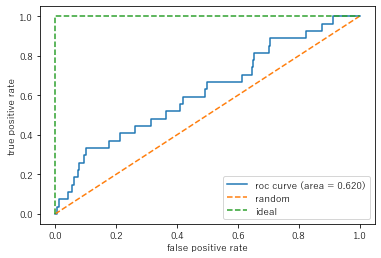

Lasso alpha=1.0
Cross-Validation scores: [0.88888889 0.86243386 0.83068783 0.82010582 0.87765957]
Average score: 0.856
使用された特徴量の数: 126

Lasso回帰
auc:0.688


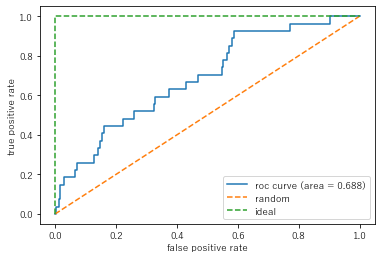

Lasso alpha=10.0
Cross-Validation scores: [0.88888889 0.86772487 0.81481481 0.78835979 0.87765957]
Average score: 0.847
使用された特徴量の数: 130

Lasso回帰
auc:0.696


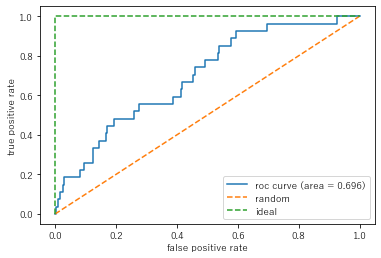

Lasso alpha=100.0
Cross-Validation scores: [0.89417989 0.85714286 0.80952381 0.79365079 0.87234043]
Average score: 0.845
使用された特徴量の数: 130

Lasso回帰
auc:0.696


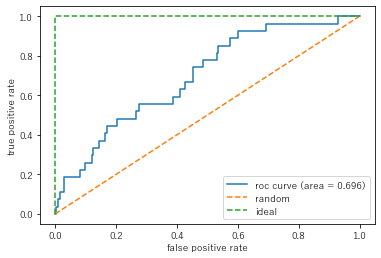

In [99]:
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_not_feature_importance,y_train)
    predict_lasso = clf_lasso.predict(x_test_not_feature_importance)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_not_feature_importance)
    
    print(f'Lasso alpha={alpha}')

    scores = cross_val_score(clf_lasso, x_train_not_feature_importance, y_train,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア

    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')
    
    Y_score = clf_lasso.predict_proba(x_test_not_feature_importance)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()


### 偶然AUCが落ちたということにならないように、下位10個を除外したパターンも用意

In [100]:
corr['abs'].sort_values()[0:10].index

Index(['415', '570', '420', '432', '547', '489', '439', '41', '187', '429'], dtype='object')

In [101]:
corr['abs'].sort_values()

415    0.001230
570    0.001438
420    0.001502
432    0.001991
547    0.003054
         ...   
510    0.110899
431    0.114916
117    0.116118
59     0.132822
21     0.145753
Name: abs, Length: 140, dtype: float64

In [102]:
x_train_not_feature_importance = x_train.copy()
x_test_not_feature_importance = x_test.copy()

x_train_not_feature_importance = x_train_not_feature_importance.drop(corr['abs'].sort_values()[0:10].index,axis=1)
x_test_not_feature_importance = x_test_not_feature_importance.drop(corr['abs'].sort_values()[0:10].index,axis=1)

Lasso alpha=0.0001
Cross-Validation scores: [0.92063492 0.92063492 0.91534392 0.91534392 0.92021277]
Average score: 0.918
使用された特徴量の数: 4

Lasso回帰
auc:0.476


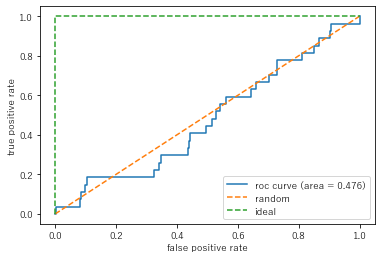

Lasso alpha=0.001
Cross-Validation scores: [0.92063492 0.92063492 0.92063492 0.9047619  0.91489362]
Average score: 0.916
使用された特徴量の数: 25

Lasso回帰
auc:0.537


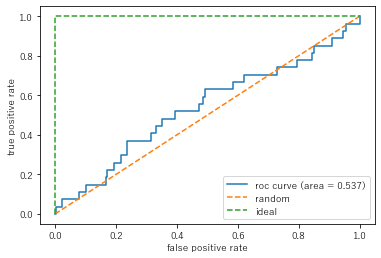

Lasso alpha=0.01
Cross-Validation scores: [0.91534392 0.91534392 0.88888889 0.88359788 0.91489362]
Average score: 0.904
使用された特徴量の数: 52

Lasso回帰
auc:0.600


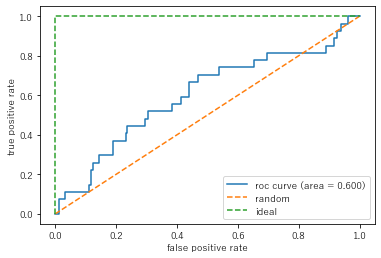

Lasso alpha=0.1
Cross-Validation scores: [0.91534392 0.87301587 0.82539683 0.85714286 0.90425532]
Average score: 0.875
使用された特徴量の数: 99

Lasso回帰
auc:0.639


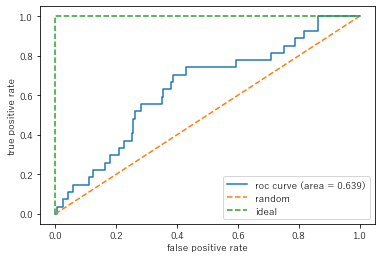

Lasso alpha=1.0
Cross-Validation scores: [0.8994709  0.87830688 0.81481481 0.83597884 0.89893617]
Average score: 0.866
使用された特徴量の数: 128

Lasso回帰
auc:0.715


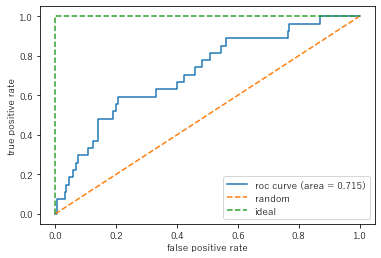

Lasso alpha=10.0
Cross-Validation scores: [0.89417989 0.86772487 0.7989418  0.83068783 0.89361702]
Average score: 0.857
使用された特徴量の数: 130

Lasso回帰
auc:0.719


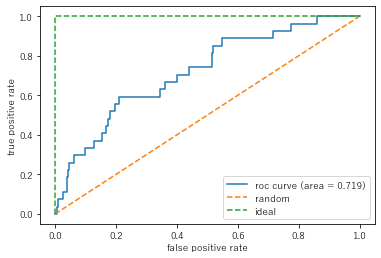

Lasso alpha=100.0
Cross-Validation scores: [0.8994709  0.86243386 0.7989418  0.83068783 0.89361702]
Average score: 0.857
使用された特徴量の数: 130

Lasso回帰
auc:0.719


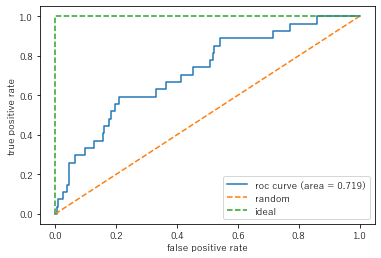

In [103]:
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_not_feature_importance,y_train)
    predict_lasso = clf_lasso.predict(x_test_not_feature_importance)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_not_feature_importance)
    
    print(f'Lasso alpha={alpha}')
    scores = cross_val_score(clf_lasso, x_train_not_feature_importance, y_train,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア
    
    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')
    
    Y_score = clf_lasso.predict_proba(x_test_not_feature_importance)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

In [104]:
df_importance.sort_values('importance')[0:10]['feature']

118    521
48     201
56     274
57     294
113    499
80     430
134    564
114    500
58     295
101    482
Name: feature, dtype: object

In [105]:
x_train_not_feature_importance = x_train.copy()
x_test_not_feature_importance = x_test.copy()

In [106]:
x_train_not_feature_importance = x_train_not_feature_importance.drop(df_importance.sort_values('importance')[0:10]['feature'],axis=1)
x_test_not_feature_importance = x_test_not_feature_importance.drop(df_importance.sort_values('importance')[0:10]['feature'],axis=1)

Lasso alpha=0.0001
Cross-Validation scores: [0.92063492 0.92063492 0.91534392 0.91534392 0.92021277]
Average score: 0.918
使用された特徴量の数: 4

Lasso回帰
auc:0.476


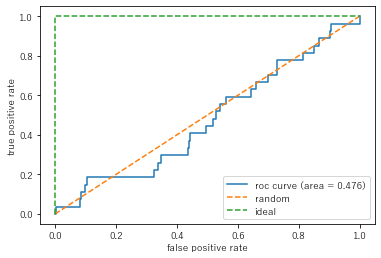

Lasso alpha=0.001
Cross-Validation scores: [0.92063492 0.92063492 0.91534392 0.9047619  0.91489362]
Average score: 0.915
使用された特徴量の数: 20

Lasso回帰
auc:0.556


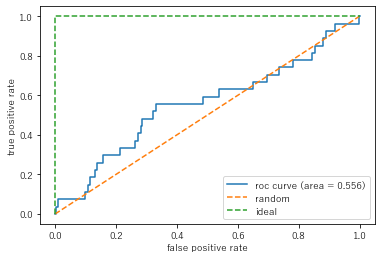

Lasso alpha=0.01
Cross-Validation scores: [0.91534392 0.91534392 0.8994709  0.89417989 0.91489362]
Average score: 0.908
使用された特徴量の数: 51

Lasso回帰
auc:0.628


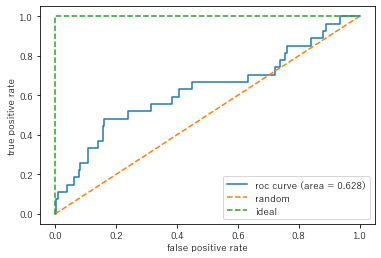

Lasso alpha=0.1
Cross-Validation scores: [0.9047619  0.88888889 0.82539683 0.87830688 0.91489362]
Average score: 0.882
使用された特徴量の数: 93

Lasso回帰
auc:0.686


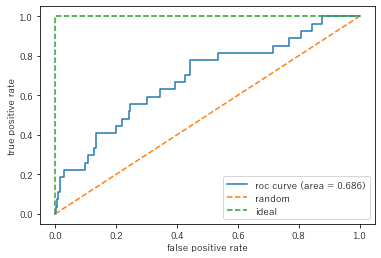

Lasso alpha=1.0
Cross-Validation scores: [0.89417989 0.88359788 0.77777778 0.84126984 0.92553191]
Average score: 0.864
使用された特徴量の数: 127

Lasso回帰
auc:0.753


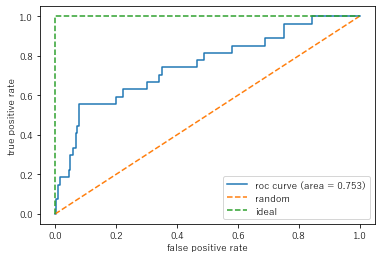

Lasso alpha=10.0
Cross-Validation scores: [0.8994709  0.87830688 0.76719577 0.84656085 0.90425532]
Average score: 0.859
使用された特徴量の数: 128

Lasso回帰
auc:0.760


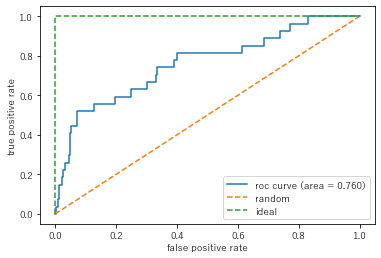

Lasso alpha=100.0
Cross-Validation scores: [0.8994709  0.87830688 0.75661376 0.84656085 0.89893617]
Average score: 0.856
使用された特徴量の数: 130

Lasso回帰
auc:0.759


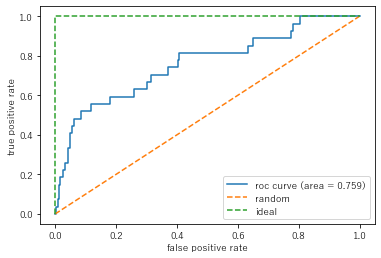

In [107]:
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_not_feature_importance,y_train)
    predict_lasso = clf_lasso.predict(x_test_not_feature_importance)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_not_feature_importance)
    
    print(f'Lasso alpha={alpha}')
    scores = cross_val_score(clf_lasso, x_train_not_feature_importance, y_train,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア
    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')
    
    Y_score = clf_lasso.predict_proba(x_test_not_feature_importance)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

#### 上位の変数を除いた時と比較して、下がり幅が少ない

## **【絞り込み】** t検定による絞り込み

In [108]:
#現時点での変数
x_train.columns

Index(['0', '1', '2', '3', '6', '14', '15', '21', '23', '24',
       ...
       '555', '557', '561', '562', '564', '569', '570', '571', '577', '589'],
      dtype='object', length=140)

In [109]:
features=x_train.columns
depend_feature_t_certificate=[]
depend_feature_u_certificate=[]

for features in features:
    # 合格
    Pass = df_median[df_median['Pass/Fail'] == 0][features]
    # 不合格
    Fail = df_median[df_median['Pass/Fail'] == 1][features]

    #対応しない2郡間の差の検定
    A_var = np.var(Pass, ddof=1)  # Aの不偏分散
    B_var = np.var(Fail, ddof=1)  # Bの不偏分散
    A_df = len(Pass) - 1  # Aの自由度
    B_df = len(Fail) - 1  # Bの自由度
    
    try:
        f = A_var / B_var  # F比の値
        one_sided_pval1 = stats.f.cdf(f, A_df, B_df)  # 片側検定のp値 1
        one_sided_pval2 = stats.f.sf(f, A_df, B_df)   # 片側検定のp値 2
        two_sided_pval = min(one_sided_pval1, one_sided_pval2) * 2  # 両側検定のp値

#         print(f'説明変数「{features}」のt検定P値:{stats.ttest_ind(Pass, Fail)[1]}')
#         print(f'説明変数「{features}」のu検定P値:{stats.mannwhitneyu(Pass, Fail, alternative='two-sided')[1]}')
        
        if stats.ttest_ind(Pass, Fail)[1] < 0.05:
            depend_feature_t_certificate.append(features)
        elif stats.mannwhitneyu(Pass, Fail, alternative='two-sided')[1] < 0.05:
            depend_feature_u_certificate.append(features)
        else:
            continue
    except ZeroDivisionError:
        pass

In [110]:
len(depend_feature_t_certificate)

34

In [111]:
x_train_t_certificate = x_train.copy()
x_test_t_certificate = x_test.copy()

x_train_u_certificate = x_train.copy()
x_test_u_certificate = x_test.copy()

#変数の選定
x_train_t_certificate = x_train_t_certificate[depend_feature_t_certificate]
x_test_t_certificate = x_test_t_certificate[depend_feature_t_certificate]

x_train_u_certificate = x_train_u_certificate[depend_feature_u_certificate]
x_test_u_certificate = x_test_u_certificate[depend_feature_u_certificate]

print(x_train_t_certificate.shape,x_test_t_certificate.shape)
print(x_train_u_certificate.shape,x_test_u_certificate.shape)

(944, 34) (623, 34)
(944, 8) (623, 8)


Lasso alpha=0.0001
Cross-Validation scores: [0.92063492 0.92063492 0.91534392 0.91534392 0.92021277]
Average score: 0.918
使用された特徴量の数: 2

Lasso回帰
auc:0.507


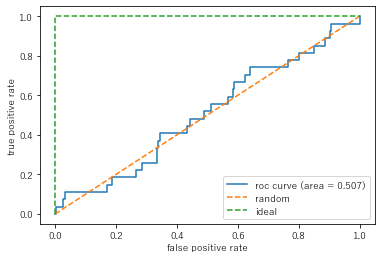

Lasso alpha=0.001
Cross-Validation scores: [0.92063492 0.92063492 0.91534392 0.91534392 0.92021277]
Average score: 0.918
使用された特徴量の数: 7

Lasso回帰
auc:0.522


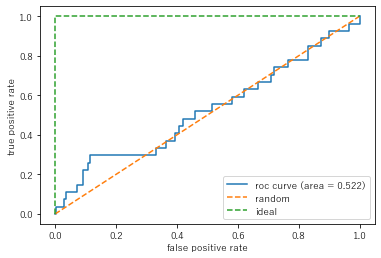

Lasso alpha=0.01
Cross-Validation scores: [0.91534392 0.92063492 0.9047619  0.91005291 0.91489362]
Average score: 0.913
使用された特徴量の数: 14

Lasso回帰
auc:0.661


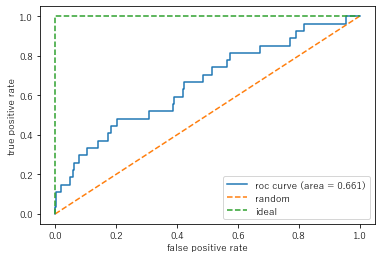

Lasso alpha=0.1
Cross-Validation scores: [0.91534392 0.91005291 0.89417989 0.9047619  0.91489362]
Average score: 0.908
使用された特徴量の数: 30

Lasso回帰
auc:0.670


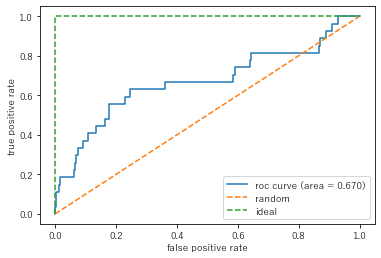

Lasso alpha=1.0
Cross-Validation scores: [0.91534392 0.8994709  0.87830688 0.9047619  0.91489362]
Average score: 0.903
使用された特徴量の数: 34

Lasso回帰
auc:0.695


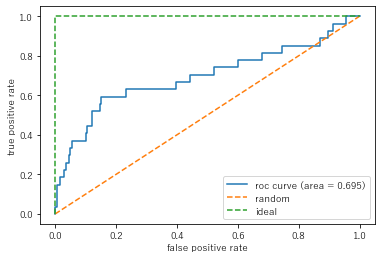

Lasso alpha=10.0
Cross-Validation scores: [0.91534392 0.8994709  0.87830688 0.9047619  0.91489362]
Average score: 0.903
使用された特徴量の数: 34

Lasso回帰
auc:0.699


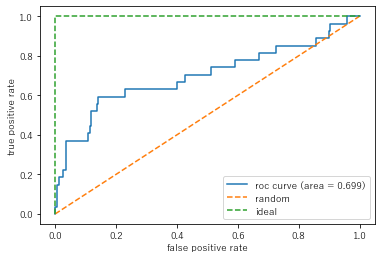

Lasso alpha=100.0
Cross-Validation scores: [0.91534392 0.8994709  0.87830688 0.9047619  0.91489362]
Average score: 0.903
使用された特徴量の数: 34

Lasso回帰
auc:0.699


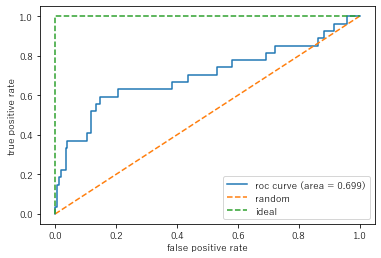

In [112]:
#t検定
#交差検証とハイパーパラメータのチューニング
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_t_certificate,y_train)
    predict_lasso = clf_lasso.predict(x_test_t_certificate)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_t_certificate)
    
    print(f'Lasso alpha={alpha}')
#     print(clf_lasso.intercept_)
#     print(clf_lasso.coef_)
    scores = cross_val_score(clf_lasso, x_train_t_certificate, y_train,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア
#     print(f'trainning data:に対しての精度: {clf_lasso.score(x_train,y_train):.3f}')
#     print(f'test data:に対しての精度: {clf_lasso.score(x_test,y_test):.3f}')
    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')
    
    Y_score = clf_lasso.predict_proba(x_test_t_certificate)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

### t検定で絞り込んだ変数での予測は下がった

### まとめ


- 本データは2008年7月~9月に集中しており、不良品の割合も多いため何らかの背景事情が存在している可能性がある
- Lasso回帰・多重共線性の確認・Group lasso回帰を行った結果有用な説明変数は140個存在する
- 単変量の観点から相関上位10個・特徴量の重要度上位10個の変数が目的変数に影響を及ぼしている推察される。特に「59」「21」「117」の説明変数が工程プロセスに大きな影響を与えていると推察される
- 多変量の観点から「65」と「224」 ,「341」と「59」 ,「40」と「426」の組み合わせが不良品に分類する際の要因となり得る